# Aberration Analysis

This code is for analyzing and characterizing aberrations and clippings of a focused gaussian beam.

# Mark's Fourier Optics Code

### General Warning about Computational Intensity:
In fourier optics, it's very easy to need to define very dense objects and calculate many of them in order to obtain the type of precision you desire. These objects can easily take up a lot of RAM on your computer, so you may consider (if you want to do lengthy calculations) doing these calculations on a computer with significant RAM (e.g. 16GB+ was sufficient for my homemwork's purposes.)

## Introduction



This ipynb contains code that I wrote mostly coming from the numerical homework assignments from my Fourier Optics course. It contains, broadly speaking, 3 things:
1. 1D and 2D Wrappers for scipy's fft algorithms that take Fourier transforms and propagate input beams, and descriptions of these wrappers
2. Many examples of usage
3. Several illustration of numerical artifacts & breakdowns of various common assumptions in Fourier optics

A useful textbook for this material is Goodman's "Fourier Optics".

Note that some of the beam propagations in this code can become relatively computationally expensive. In order to do these calculations accurately, one must provide sufficient sampling of the field being propagated or transformed, and if doing significantly complicated diffractions or similar methods, it can be very useful to create and plot a large sum of data as the beam propagates through space (see the colorplots below).


## Setup

In [3]:
import numpy as np
import matplotlib as mpl
from mpl_toolkits.mplot3d import axes3d
from matplotlib.pyplot import *
import scipy.fftpack as FT
import scipy.special as special
import math as m
import sys
from matplotlib import rcParams
from matplotlib import style
%matplotlib inline

# ## set matplotlib plot defaults :D
# Style controls many default colors in matplotlib plots.
# Change the following if you don't like dark backgrounds. Many other options.
style.use(['seaborn-darkgrid'])
#style.use(['seaborn-dark-palette'])

### old solarized stuff
# style.use(['dark_background'])
# mpl.rcParams['axes.facecolor'] = '#0a0a0a'
# the default cycling of colors in this mode isn't very good.
# mpl.rcParams['axes.prop_cycle'] = cycler('color', ['r','c','g','#FFFFFF','y','m','b'])
### General
rcParams['figure.figsize'] = (18.0, 8.0)
rcParams['axes.grid'] = True
rcParams['axes.formatter.useoffset'] = False
rcParams['grid.alpha'] = 0.3
rcParams['axes.formatter.limits'] = (-3,3)
# jet is awful.
rcParams['image.cmap'] = 'viridis'
# to see all available options, decomment this line.
# print(mpl.rcParams)
rcParams['font.size'] = 14

## 2D Fourier Wrappers

##### **Some theory**

The transfer function $T\{f,z_{fin}\}$ in free space for a frequency $f$ from position $z=0$ to position $z=z_{fin}$ in a medium with index of refraction $n$ is
$$
    T\{f,z_{fin}\} = \exp{\bigg\{ i k  z_{fin} \times \sqrt{1 - \bigg(\frac{\lambda f}{n}\bigg)^2}\bigg\}},\\
    k = \frac{2\pi}{\lambda}.
$$

##### Calculation

In [5]:
def fft2D(field, xpts, ypts, normalize=True):
    """
    :@param field: the field amplitudes of the field to be transformed
    :@param xpts: the positions that the field array above have been sampled at. Note that this function assumes
        evenly spaced points.
    :@param ypts: the positions that the field array above have been sampled at. Note that this function assumes
        evenly spaced points.
    Takes the fourier transform of a 2-dimensional field, i.e. g{x} -> g_f{f_x}
    returns the transform amplitudes and the frequencies in two objects.
    """
    assert(len(xpts) > 1)
    assert(len(ypts) > 1)
    assert(len(xpts) == len(field))
    assert(len(ypts) == len(field[0]))
    xspacing = (max(xpts) - min(xpts))/(len(xpts) - 1)    
    yspacing = (max(ypts) - min(ypts))/(len(ypts) - 1)    
    xFreqs = FT.fftshift(FT.fftfreq(len(xpts), xspacing))
    yFreqs = FT.fftshift(FT.fftfreq(len(ypts), yspacing))
    fieldFFT = FT.fftshift(FT.fft2(FT.ifftshift(field)))
    if normalize:
        fieldFFT *= (xspacing * yspacing)
    return {'Amp': fieldFFT, 'xFreq': xFreqs, 'yFreq': yFreqs}


def ifft2D(field2DFFT, xpts, ypts, denormalize=True):
    """
    @param field2DFFT: the 2D field frequency amplitudes 
    
    Takes the inverse fourier transform of a 2-dimensional field;
    returns the amplitudes (presumably you already have the x points for those amplitudes.)
    """
    assert(len(field2DFFT) > 1)
    field = FT.fftshift(FT.ifft2(FT.ifftshift(field2DFFT)))
    if denormalize:
        xspacing = (max(xpts) - min(xpts))/(len(xpts) - 1)    
        yspacing = (max(ypts) - min(ypts))/(len(ypts) - 1)    
        field /= xspacing * yspacing
    return {'Field': field, 'xpts': xpts, 'ypts': ypts}


In [6]:
def propagate2D(field, fieldPosX, fieldPosY, z_fin, wavelength, n=1):
    """
    Propagate a field a given distance.
    """
    k = 2 * np.pi * n / wavelength
    # Important assumption in the following line.
    xSpacing = (max(fieldPosX) - min(fieldPosX))/(len(fieldPosX) - 1)
    if not (xSpacing <= wavelength / 2):
        print('WARNING: spacing is not sufficient to see evanescant frequencies in X direction.'
              ' Spacing is ' + str(xSpacing))
    ySpacing = (max(fieldPosY) - min(fieldPosY))/(len(fieldPosY) - 1)
    if not (ySpacing <= wavelength / 2):
        print('WARNING: spacing is not sufficient to see evanescant frequencies in Y direction.'
              ' Spacing is ' + str(ySpacing))
    theFft = fft2D(field, fieldPosX, fieldPosY)
    #fieldFFT, xFreqs, yFreqs = 
    transferFunc = np.zeros((len(theFft['xFreq']), len(theFft['yFreq']))).astype(complex)
    for x in range(len(theFft['xFreq'])):
        for y in range(len(theFft['yFreq'])):
            transferFunc[x][y] = np.exp(1j * k * z_fin * 
                                        np.sqrt((1 - ((wavelength / n) * theFft['xFreq'][x])**2 
                                                 - ((wavelength / n) * theFft['yFreq'][y])**2).astype(complex)))
            #transferFunc[x][y] = (1j * k * z_fin * 
            #                            np.sqrt((1 - ((wavelength / n) * theFft['xFreq'][x])**2 
            #                                     - ((wavelength / n) * theFft['yFreq'][y])**2).astype(complex)))
    propFieldFFT = theFft['Amp'] * transferFunc
    field = np.array([], dtype=complex)
    propField = ifft2D(propFieldFFT, fieldPosX, fieldPosY)
    return propField

In [7]:
def propagateMany2D(field, fieldPosX, fieldPosY, z_positions, wavelength, n=1, quiet=False):
    """
    Propagate a field to given distances. Avoids needing to take the FFT of the input or calculate a certain
    factor redundantly. Only returns fields.
    """
    k = 2 * np.pi * n / wavelength
    # Important assumption in the following line.
    xSpacing = (max(fieldPosX) - min(fieldPosX))/(len(fieldPosX) - 1)
    if not (xSpacing <= wavelength / 2):
        print('WARNING: spacing is not sufficient to see evanescant frequencies in X direction.'
              ' Spacing is ' + str(xSpacing))
    ySpacing = (max(fieldPosY) - min(fieldPosY))/(len(fieldPosY) - 1)
    if not (ySpacing <= wavelength / 2):
        print('WARNING: spacing is not sufficient to see evanescant frequencies in Y direction.'
              ' Spacing is ' + str(ySpacing))
    if not quiet:
        print('Calculating Initial fourier transform of input...', end='')        
    theFft = fft2D(field, fieldPosX, fieldPosY)
    # calculate common factor matrix
    if not quiet:
        print('Calculating common propagation factor...', end='')
    xFreqs, yFreqs = np.meshgrid(theFft['xFreq'], theFft['yFreq'])
    commonFactor = 1j * k * np.sqrt((1 - ((wavelength / n) * xFreqs)**2 
                                     - ((wavelength / n) * yFreqs)**2).astype(complex))    
    if not quiet:
        print('Fin.')
    # this step allocates a lot of memory.
    finFields = np.zeros((len(z_positions), xFreqs.shape[0], xFreqs.shape[1]))
    for i, z_fin in enumerate(z_positions):
        if not quiet:
            print('Calculating position #', i, 'Transfer Function...', end='')
        else:
            print( str(i) + ',', end='')
        transferFunc = np.zeros((len(theFft['xFreq']), len(theFft['yFreq']))).astype(complex)
        transferFunc = np.exp( z_fin * commonFactor ).astype(complex)
        if not quiet:
            print('Propagating Field...', end='')
        propFieldFFT = theFft['Amp'] * transferFunc
        field = np.array([], dtype=complex)
        if not quiet:
            print('Inverting Propagated Field...', end='')
        num = (26585.594181612469 * 1.10322800716)
        dp = ifft2D(propFieldFFT, fieldPosX, fieldPosY)['Field']
        finFields[i] = np.real(dp * dp.conjugate()) * num
        if not quiet:
            clear_output(wait=True)
    return finFields

# Building to full Calculations

## Aberrations: P2P normalized

## Aberrations: RMS normalized

Aberrations are represented as phases of the form

$$
\exp\Big\{-i \frac{2\pi}{\lambda} Z_{i,j}\{x,y\}\Big\}
$$

Where $Z_{i,j}$ are the zernike polynomials, whose formula were taken from wiki:
https://en.wikipedia.org/wiki/Zernike_polynomials

For sanity dealing with odd-sized numbers, Z is in units of lambda.

In [8]:
def getAngular(x, y, waist):
    rho_0 = np.sqrt(x**2+y**2)
    return rho_0 / waist, np.arctan2(x,y)

In [9]:
from math import factorial as fac
def zernikeString(n,m):
    k = int((n-m)/2)
    normFactor = 2*n+2
    if m == 0:
        normFactor /= 2
    function = 'Z_('+ str(n) + ',' + str(m) + ') = sqrt(' + str(normFactor) + '/pi)*['
    while k>=0:
        pre = ((-1)**k * fac(n-k))/(fac(k)*fac((n+m)/2-k)*fac((n-m)/2-k))
        function += str(int(pre)) + 'r^(' + str(n-2*k) + ') +'
        k -= 1
    function = function[:-2]
    function += ']*sin(' + str(m) + ' * theta)'    
    return function

In [10]:
from math import factorial as fac
def zernike(n, m, x, y, waist, scale):
    r, theta = getAngular(x,y, waist)
    k = int(abs(n-m)/2)
    normFactor = 2*n+2
    if m == 0:
        normFactor /= 2.0
    normFactor = np.sqrt(normFactor/np.pi)
    radialTerm = 0
    while k>=0:
        pre = ((-1)**k * fac(abs(n-k)))/(fac(k)*fac(abs((n+m)/2-k))*fac(abs((n-m)/2-k)))
        radialTerm += pre * r**(abs(n-2*k))
        k -= 1
    if m <= 0:
        angularTerm = np.cos(m*theta) 
    else:
        angularTerm = np.sin(m*theta)    
    return np.exp(-1j * 2 * np.pi * scale * normFactor * radialTerm * angularTerm)

In [11]:
def vertComa(x, y, waist, scale=1):
    """
    Z_{3,-1}
    """
    rho, theta = getAngular(x, y, waist)
    return np.exp(-1j * 2 * np.pi * scale * np.sqrt(8/np.pi) * (3 * rho**3 - 2 * rho) * np.sin(theta) )

### Z=0, 1

Boring

### Z=2

In [12]:
import sympy as sp
sp.init_printing(use_latex=True)

In [13]:
r = sp.Symbol('rho', positive=True)
theta = sp.Symbol('theta', positive=True)
Z22 = sp.cos(20*theta)
sp.sqrt(sp.integrate(Z22**2, [theta, 0, 2*sp.pi]))

In [637]:
def obliqueAstigmatism(x, y, waist, scale=1):
    """
    Z_{2,-2}
    """
    rho, theta = getAngular(x, y, waist)
    return np.exp(-1j * 2 * np.pi * scale * np.sqrt(6/np.pi)*rho**2*np.sin(2*theta) )

In [638]:
def astigmatism(x, y, waist, scale=1):
    """
    Z_{2,2}
    """
    rho, theta = getAngular(x, y, waist)
    return np.exp(-1j * 2 * np.pi * scale * np.sqrt(6/np.pi)*rho**2*np.cos(2*theta) )

In [639]:
def defocus(x, y, waist):
    """
    Z_{2,0}
    """
    rho, theta = getAngular(x, y, waist)
    return np.exp(1j * 2 * np.pi * scale * np.sqrt(3/np.pi)*(2*rho**2-1) )

### Z=3

In [522]:
import sympy as sp
sp.init_printing(use_latex=True)

In [629]:
r = sp.Symbol('rho', positive=True)
theta = sp.Symbol('theta', positive=True)
Z22 = sp.sqrt(2)*r**3*sp.cos(3*theta)
sp.sqrt(sp.integrate(Z22**2*r, [r, 0,1], [theta, 0, 2*sp.pi]))

In [640]:
def trefoil(x, y, waist, scale=1):
    rho, theta = getAngular(x, y, waist)
    return np.exp(-1j * 2 * np.pi * scale * np.sqrt(8/np.pi) * rho**3 * np.sin(3*theta))

In [641]:
def obliqueTrefoil(x, y, waist, scale=1):
    """
    Z_{3,3}
    """
    rho, theta = getAngular(x, y, waist)
    return np.exp(-1j * 2 *np.pi* scale * np.sqrt(8/np.pi) * rho**3 * np.cos(3*theta))

In [642]:
def horComa(x, y, waist, scale=1):
    """
    Z_{3,1}
    """
    rho, theta = getAngular(x, y, waist)
    return np.exp(-1j * 2*np.pi * scale * np.sqrt(8/np.pi) * (3 * rho**3 - 2 * rho) * np.cos(theta) )

In [643]:
def vertComa(x, y, waist, scale=1):
    """
    Z_{3,-1}
    """
    rho, theta = getAngular(x, y, waist)
    return np.exp(-1j * 2 * np.pi * scale * np.sqrt(8/np.pi) * (3 * rho**3 - 2 * rho) * np.sin(theta) )

### Z=4

In [644]:
def obliqueQuadrafoil(x, y, waist, scale=1 ):
    """
    Z_{4,-4}
    """
    rho, theta = getAngular(x, y, waist)
    return np.exp(-1j * 2 * np.pi * scale * np.sqrt(10/np.pi)*rho**4*np.sin(4*theta))

In [645]:
def quadrafoil(x, y, waist, scale=1 ):
    """
    Z_{4,4}
    """
    rho, theta = getAngular(x, y, waist)
    return np.exp(-1j * 2 * np.pi * scale * np.sqrt(10/np.pi)*rho**4*np.cos(4*theta))

In [646]:
def primarySpherical(x, y, waist, scale=1):
    """
    Z_{4,0}
    """
    rho, theta = getAngular(x, y, waist)
    return np.exp(-1j * 2 * np.pi * scale * np.sqrt(5/np.pi)*(6*rho**4-6*rho**2+1))

In [647]:
def secondaryObliqueAstigmatism(x, y, waist, scale=1):
    rho, theta = getAngular(x, y, waist)
    return np.exp(-1j * 2 * np.pi * scale * np.sqrt(10/np.pi)*(4*rho**4-3*rho**2)*np.sin(2*theta))

In [648]:
def secondaryAstigmatism(x, y, waist, scale=1):
    rho, theta = getAngular(x, y, waist)
    return np.exp(-1j * 2 * np.pi * scale * np.sqrt(10/np.pi)*(4*rho**4-3*rho**2)*np.cos(2*theta))

### Z=5

In [522]:
import sympy as sp
sp.init_printing(use_latex=True)

In [663]:
r = sp.Symbol('rho', positive=True)
theta = sp.Symbol('theta', positive=True)
Z22 = sp.cos(20*theta)
sp.sqrt(sp.integrate(Z22**2, [theta, 0, 2*sp.pi]))

In [667]:
Z = sp.sqrt(12/sp.pi) * (5*r**5-4*r**3) * sp.cos(5*theta)
sp.integrate(Z**2*r, [r,0,1], [theta,0,2*sp.pi])

In [669]:
def quintaFoil(x,y,waist,scale):
    rho, theta = getAngular(x, y, waist)
    return np.exp(-1j * 2 * np.pi * scale * np.sqrt(12/np.pi)*(rho**5)*np.cos(5*theta))

In [670]:
def Z_53(x,y,waist,scale=1):
    """
    Name?
    """
    rho, theta = getAngular(x, y, waist)
    return np.exp(-1j * 2 * np.pi * scale * np.sqrt(12/np.pi)*(5*rho**5-4*rho**3)*np.cos(3*theta))

In [671]:
def secondaryComa(x,y,waist,scale=1):
    rho, theta = getAngular(x, y, waist)
    return np.exp(-1j * 2 * np.pi * scale * np.sqrt(12/np.pi)*(10*rho**5-12*rho**3+3*rho)*np.cos(theta))

### Z=6

In [522]:
import sympy as sp
sp.init_printing(use_latex=True)

In [736]:
r = sp.Symbol('rho', positive=True)
theta = sp.Symbol('theta', positive=True)
Z22 = sp.cos(20*theta)
sp.sqrt(sp.integrate(Z22**2, [theta, 0, 2*sp.pi]))

In [738]:
Z = sp.sqrt(7/sp.pi) * (20*r**6-30*r**4+12*r**2-1)
sp.integrate(Z**2*r, [r,0,1], [theta,0,2*sp.pi])

In [731]:
def sexaFoil(x,y,waist,scale):
    rho, theta = getAngular(x, y, waist)
    return np.exp(-1j * 2 * np.pi * scale * np.sqrt(14/np.pi)*(rho**6)*np.cos(6*theta))

In [732]:
def quadrafoil_2(x,y,waist,scale=1):
    """
    Name?
    """
    rho, theta = getAngular(x, y, waist)
    return np.exp(-1j * 2 * np.pi * scale * np.sqrt(14/np.pi)*(6*rho**6-5*rho**4)*np.cos(4*theta))

In [733]:
def astigmatism_3(x,y,waist,scale=1):
    rho, theta = getAngular(x, y, waist)
    return np.exp(-1j * 2 * np.pi * scale * np.sqrt(14/np.pi)*(15*rho**6-20*rho**4+6*rho**2)*np.cos(2*theta))

In [734]:
def spherical_2(x,y,waist,scale=1):
    rho, theta = getAngular(x, y, waist)
    return np.exp(-1j * 2 * np.pi * scale * np.sqrt(7/np.pi)*(20*rho**6-30*rho**4+12*rho**2-1))

## Functions

In [14]:
def getAxialFreqs(data, fitArea, picSpacing=1, ampScale=1):
    #data = abs(data)
    #data = data * ampScale / max(data.flatten())
    indexes = np.unravel_index(np.argmax(data), data.shape)
    line = deepcopy(data[:,indexes[1], indexes[2]])
    line = arr(line[int(np.floor(len(line)/2-fitArea)):int(np.ceil(len(line)/2+fitArea))]) * 1e-3 * mc.k_B
    xpts = picSpacing*arr(range(len(line)))
    guess = [max(line),-1000*mc.k_B/(10*picSpacing), xpts[np.argmax(line)]]
    fitParams, fitCov = curve_fit(quadratic_bump.f, picSpacing*arr(range(len(line))),
                                  line, p0=guess)
    #f, ax = subplots(figsize=(3,3))
    #ax.plot(xpts, line, label='Data')
    #ax.plot(xpts, quadratic_bump.f(xpts, *fitParams), label='Fit')
    #legend()
    omega = np.sqrt(-2*fitParams[1]/mc.Rb87_M)
    return omega / (2*np.pi)

In [15]:
def getRadialFreqs(data, fitAreaRadius, picScale=1, ampScale=1):
    indexes = np.unravel_index(np.argmax(data), data.shape)
    left, right = int(indexes[1]-2*fitAreaRadius), int(indexes[1]+2*fitAreaRadius)
    top, bottom = int(indexes[2]-2*fitAreaRadius), int(indexes[2]+2*fitAreaRadius)
    pic = deepcopy(data[indexes[0], left:right, top:bottom])
    # pic at this point is in mK. Want joules. 
    pic *= 1e-3 * mc.k_B
    indexes = np.unravel_index(np.argmax(pic), pic.shape)
    xpts, ypts, fitData = [[] for _ in range(3)]
    # Isolate list of points
    for r, row in enumerate(pic):
        for c, element in enumerate(row):
            if np.sqrt((r-indexes[0])**2+(c-indexes[1])**2) < fitAreaRadius:
                xpts.append(r)
                ypts.append(c)
                fitData.append(element)
    xVals = arr(xpts) * picScale
    yVals = arr(ypts) * picScale
    showData = np.zeros(pic.shape)
    for x, y, z in zip(xpts, ypts, fitData):
        showData[x, y] = z
    coords = [xVals, yVals]
    guess = [picScale*indexes[0], picScale*indexes[1], 
                                      -1e-6/(picScale), -1e-6/(picScale), max(pic.flatten())]
    fitParams, fitCov = curve_fit(quadratic_2d.f, coords, fitData, p0=guess)
    fitResult = np.zeros(pic.shape)
    for x, xv, y, yv in zip(xpts, xVals, ypts, yVals):
        fitResult[x,y] = quadratic_2d.f((xv,yv), *fitParams)
    f, axes = subplots(1,3, figsize=(15,3))
    axes[0].imshow(fitResult, vmin=0, vmax=max(showData.flatten()))
    axes[0].set_title('Fit')
    axes[1].imshow(showData, vmin=0, vmax=max(showData.flatten()))
    axes[1].set_title('data')
    axes[2].imshow(showData-fitResult,vmin=0, vmax=max(showData.flatten()))
    axes[2].set_title('diff')
    grid(0)
    avgErr = np.sqrt(np.sum((showData-fitResult)**2))/ (len(xpts)*max(showData.flatten()))
    return np.sqrt(-fitParams[2]/mc.Rb87_M)/(2*np.pi), np.sqrt(-fitParams[3]/mc.Rb87_M)/(2*np.pi), avgErr

In [16]:
import MarksConstants as mc
from numpy import array as arr
from scipy.optimize import curve_fit
from fitters import quadratic_2d, quadratic_bump
from importlib import reload
reload(quadratic_2d)
import numpy as np
from fitters import gaussian_2d
from IPython.display import clear_output
from bokeh.io import reset_output, output_notebook, output_file
from bokeh.plotting import figure, show, ColumnDataSource, save
from bokeh.palettes import Viridis256
from bokeh.models import CustomJS, Slider, LinearColorMapper, LogColorMapper
from bokeh.layouts import column

In [17]:
def calcBaseField(dim, waist, focalLength, pts):
    xAxis = np.linspace(-dim, dim, pts)
    yAxis = np.linspace(-dim, dim, pts)
    field0 = np.zeros((len(xAxis), len(yAxis))).astype(complex)
    rayleighLength = np.pi * waist**2/850e-9
    newWaist = waist*np.sqrt(1+(10/rayleighLength)**2)
    xx, yy = np.meshgrid(xAxis, yAxis)
    focusingPhase = np.exp(-1j * (2*np.pi / 850e-9) * focalLength * np.sqrt(1+(xx**2+yy**2)/focalLength**2))
    rho = np.sqrt(xx**2 + yy**2)
    aperture=rho<=waist
    gaussianProfile = np.reshape(gaussian_2d.f((xx,yy), 1, 0,0, waist/np.sqrt(2), waist/np.sqrt(2), 0, 0), 
                                 xx.shape)
    field0 = gaussianProfile * focusingPhase * aperture
    return field0

def calcBaseField(dim, waist, focalLength, focalRange, pts):
    xAxis = np.linspace(-dim, dim, pts)
    yAxis = np.linspace(-dim, dim, pts)
    field0 = np.zeros((len(xAxis), len(yAxis))).astype(complex)
    rayleighLength = np.pi * waist**2/850e-9
    newWaist = waist*np.sqrt(1+(10/rayleighLength)**2)
    for i, x in enumerate(xAxis):
        for j, y in enumerate(yAxis):
            focusingPhase = np.exp(-1j * (2*np.pi / 850e-9) * focalLength * np.sqrt(1+(x**2+y**2)/focalLength**2))
            rho = np.sqrt(x**2 + y**2)
            aperture=int(rho<=waist)
            gaussianProfile = gaussian_2d.f((x,y), 1, 0,0, waist/np.sqrt(2), waist/np.sqrt(2), 0, 0)
            field0[i,j] = gaussianProfile * focusingPhase * aperture
    return field0

In [18]:
import time

In [19]:
def doPropsAroundWaist_2(dim, waist, focalLength, focalRange, pts, numPositions, aberration=None, 
                         field0=None, aberrationScale=1, quiet=False ):
    """
    
    """
    xAxis = np.linspace(-dim, dim, pts)
    yAxis = np.linspace(-dim, dim, pts)
    if field0 is None or aberration is not None:
        print('Initializing...', end='')
    if field0 is None:
        print('Calculating Base Field...', end='')
        field0 = calcBaseField(dim, waist, focalLength, focalRange, pts)
    if aberration is not None:
        print('Calculating Abberation Mask...', end='')
        xx, yy = np.meshgrid(xAxis, yAxis)
        aberrationPhase = aberration(xx, yy, waist, scale=aberrationScale)
        field0 *= aberrationPhase
    print('Fin.')
    
    # The following is pretty standard for generating a picture of how the field propagates
    positions = np.linspace(focalRange[0]*focalLength, focalRange[1]*focalLength, numPositions)
    # important to set as complex here, else it tries to convert `to real immediately.
    # Creating propagated data.
    #allData = np.zeros((len(positions), field0.shape[0], field0.shape[1]), dtype=complex)
    print('Starting Propagation...', end='')
    allData = propagateMany2D(field0, xAxis, yAxis, positions, 850e-9, quiet=quiet)
    print('fin.')
    return allData

In [20]:
def doPropsAroundWaist(dim, waist, focalLength, focalRange, pts, numPositions, aberration=None, field0=None, 
                       aberrationScale=1):
    """
    
    """
    xAxis = np.linspace(-dim, dim, pts)
    yAxis = np.linspace(-dim, dim, pts)
    if field0 is None or aberration is not None:
        print('Initializing...', end='')
    if field0 is None:
        print('Calculating Base Field...', end='')
        field0 = calcBaseField(dim, waist, focalLength, focalRange, pts)
    if aberration is not None:
        print('Calculating Abberation Mask...', end='')
        for i, x in enumerate(xAxis):
            for j, y in enumerate(yAxis):
                if aberration is not None:
                    aberrationPhase = aberrationScale * aberration(x, y, waist, scale=aberrationScale)
                else:
                    aberrationPhase = 1
                field0[i,j] *= aberrationPhase
    print('Initialized.')
    mKConversion = 4.77389896909e-29
    # The following is pretty standard for generating a picture of how the field propagates
    positions = np.linspace(focalRange[0]*focalLength, focalRange[1]*focalLength, numPositions)
    # important to set as complex here, else it tries to convert `to real immediately.
    # Creating propagated data.
    allData = np.zeros((len(positions), field0.shape[0], field0.shape[1]), dtype=complex)
    for i, pos in enumerate(range(len(positions))):
        print('Initializing Field...Done.\nCreating Propagation #'+str(i)+'...')
        allData[pos] = np.abs(propagate2D(field0, xAxis, yAxis, positions[pos], 850e-9)['Field'])**2
        # normalize to 1mk trap depth
        allData[pos] *= (1e-3*mc.k_B)/mKConversion
        clear_output(wait=True)
    print('fin.')
    return allData

In [21]:
def createInteractivePlot(allData, name, scaleFactor=4, logMap=False):
    """
    Creates a nice interactive bokeh plot.
    """
    reset_output()
    output_file(name, title=name)    
    xs = allData.shape[1]
    ys = allData.shape[2]
    shrunkData = allData[:,int(xs/2-xs/(2*scaleFactor)):int(xs/2+xs/(2*scaleFactor)),
                         int(ys/2-ys/(2*scaleFactor)):int(ys/2+ys/(2*scaleFactor))]
    minVal = min(shrunkData.flatten())
    maxVal = max(shrunkData.flatten())
    if logMap:
        color_mapper = LogColorMapper(palette="Viridis256", low=minVal, high=maxVal)
    else:
        color_mapper = LinearColorMapper(palette="Viridis256", low=minVal, high=maxVal)
    s = figure(x_range=(0, 10), y_range=(0, 10))
    ds = ColumnDataSource(data=dict(image=[shrunkData[0]]))
    ds2 = ColumnDataSource(data=dict(image=[shrunkData]))
    s.image(image='image', x=0, y=0, dw=10, dh=10, source=ds, 
           color_mapper=color_mapper)
    callback_which = CustomJS(args=dict(source=ds), 
                              code=
    """
        var imageLength = source.data['image'][0].length
        var offset = which.value * imageLength
        for (i = 0; i < imageLength; i++) 
        {
            source.data['image'][0][i] = allData.data['image'][0][offset+i]
        }
        source.data['image'][0][0] = 10;
        source.change.emit();
    """);
    whichSlider = Slider(start=0, end=len(shrunkData)-1, value=1, step=1, 
                         title="Which", callback=callback_which, width=550)
    callback_which.args["which"] = whichSlider
    callback_which.args["allData"] = ds2
    layout = column( s, whichSlider )
    save(layout)

## 2D Gaussian Beam Propagation

In [136]:
from fitters import gaussian_2d

In [137]:
# initialize the field
xAxis = np.linspace(-6e-3, 6e-3, 500)
yAxis = np.linspace(-6e-3, 6e-3, 500)
# e.g. this 1/10th the waist of the input ot the sill lens.
waist = 1e-3
rayleighLength = np.pi*waist**2/850e-9
print(rayleighLength)

3.6959913571644623


Careful thinking about the field vs. intensity fits here.

$$
E\{x\} = \exp\Big\{-\frac{x^2}{\sigma_E^2}\Big\}
$$
$$
I\{x\} =E\{x\}^2= \exp\Big\{-2\frac{x^2}{\sigma_E^2}\Big\}=\exp\Big\{-2\frac{x^2}{w^2}\Big\}
$$

The waist of the field is the "1/e" $\sigma$ of the E-field.

But my "gaussian_2d" function is defined as
$$
\exp\Big\{ -\frac{x^2}{2\sigma^2} \Big\}
$$
so $w^2=2\sigma^2$, $\sigma=w/\sqrt{2}$, so knowing $w$, you should plug in $w/\sqrt{2}$ for the waist here.

In [138]:
field0 = np.zeros((len(xAxis), len(yAxis)))
predField = np.zeros((len(xAxis), len(yAxis)))
newWaist = waist*np.sqrt(1+(10/rayleighLength)**2)
for i, x in enumerate(xAxis):
    for j, y in enumerate(yAxis):
        field0[i,j] = gaussian_2d.f((x,y), 1, 0,0, waist/np.sqrt(2), waist/np.sqrt(2), 0, 0)        
        predField[i, j] = waist/newWaist * gaussian_2d.f((x,y), 1, 0,0, newWaist/np.sqrt(2), newWaist/np.sqrt(2), 0, 0)

In [139]:
# The following is pretty standard for generating a picture of how the field propagates
positions = np.linspace(0, 10, 2)
# important to set as complex here, else it tries to convert `to real immediately.
allData = np.zeros((len(positions), field0.shape[0], field0.shape[1]), dtype=complex)
for pos in range(len(positions)):
    allData[pos] = propagate2D(field0, xAxis, yAxis, positions[pos], 850e-9)['Field']

##### Results

2716.17955672
2716.17955672
2716.01301398


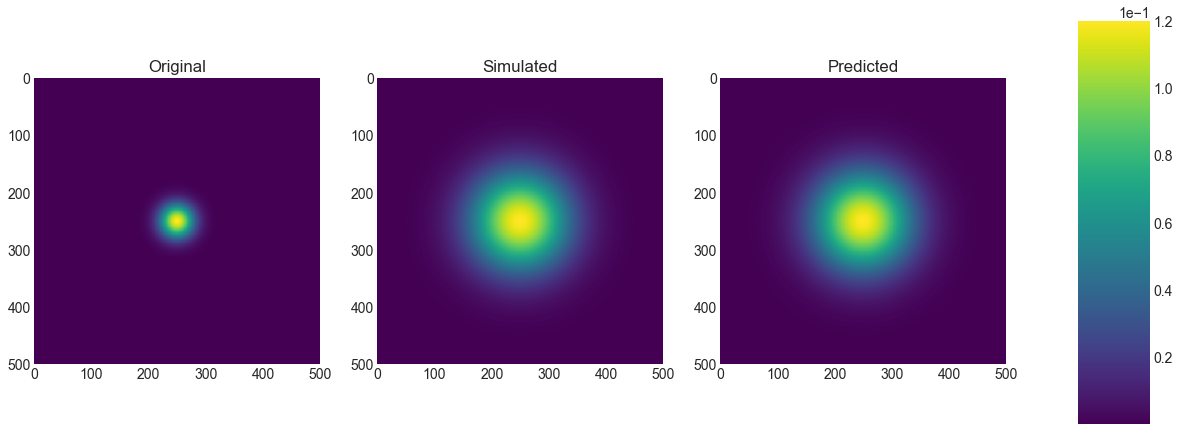

In [140]:
# Two subplots, the axes array is 1-d
f, axarr = subplots(1,3)
f.set_figwidth(20)
axarr[0].imshow(abs(field0)**2)
axarr[0].grid(0)
axarr[0].set_title('Original')
for i, ax in enumerate(axarr[1:-1]):
    im = ax.imshow(abs(allData[i+1])**2)
    ax.grid(0)
    ax.set_title('Simulated')
axarr[-1].imshow(abs(predField)**2)
axarr[-1].grid(0)
axarr[-1].set_title('Predicted')
print(np.sum(abs(field0)**2))
print(np.sum(abs(allData[-1])**2))
print(np.sum(abs(predField)**2))
f.subplots_adjust(right=0.8)
cbar_ax = f.add_axes([0.85, 0.15, 0.05, 0.7])
f.colorbar(im, cax=cbar_ax)

very good matching. In the plot below, you can see the difference between the predicted and simulated is some very high order frequencies that spread out fast in the simulation and hit the edges of the numerical region.

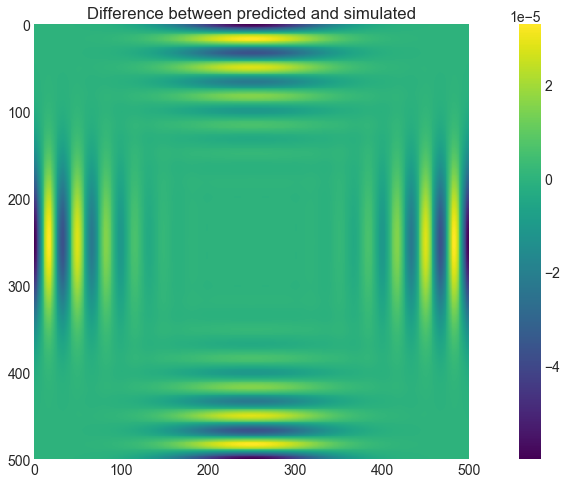

In [141]:
imshow(abs(predField)**2-abs(allData[-1])**2)
title('Difference between predicted and simulated')
grid(0)
colorbar()

### Focused 2D Gaussian Beam

Focused pretty tightly right now.

In [142]:
# initialize the field
xAxis = np.linspace(-1e-3, 1e-3, 500)
yAxis = np.linspace(-1e-3, 1e-3, 500)
# e.g. this 1/10th the waist of the input ot the sill lens.
waist = 5e-4
rayleighLength = np.pi*waist**2/850e-9
focalLength=0.2

In [143]:
field0 = np.zeros((len(xAxis), len(yAxis))).astype(complex)
newWaist = waist*np.sqrt(1+(10/rayleighLength)**2)
for i, x in enumerate(xAxis):
    for j, y in enumerate(yAxis):
        focusingPhase = np.exp(-1j * (2*np.pi / 850e-9) * focalLength * np.sqrt(1+(x**2+y**2)/focalLength**2))
        gaussianProfile = gaussian_2d.f((x,y), 1, 0,0, waist/np.sqrt(2), waist/np.sqrt(2), 0, 0)
        field0[i,j] = gaussianProfile * focusingPhase

In [144]:
# The following is pretty standard for generating a picture of how the field propagates
positions = np.linspace(0, focalLength, 5)
# important to set as complex here, else it tries to convert `to real immediately.
allData = np.zeros((len(positions), field0.shape[0], field0.shape[1]), dtype=complex)
for pos in range(len(positions)):
    allData[pos] = propagate2D(field0, xAxis, yAxis, positions[pos], 850e-9)['Field']

##### Results

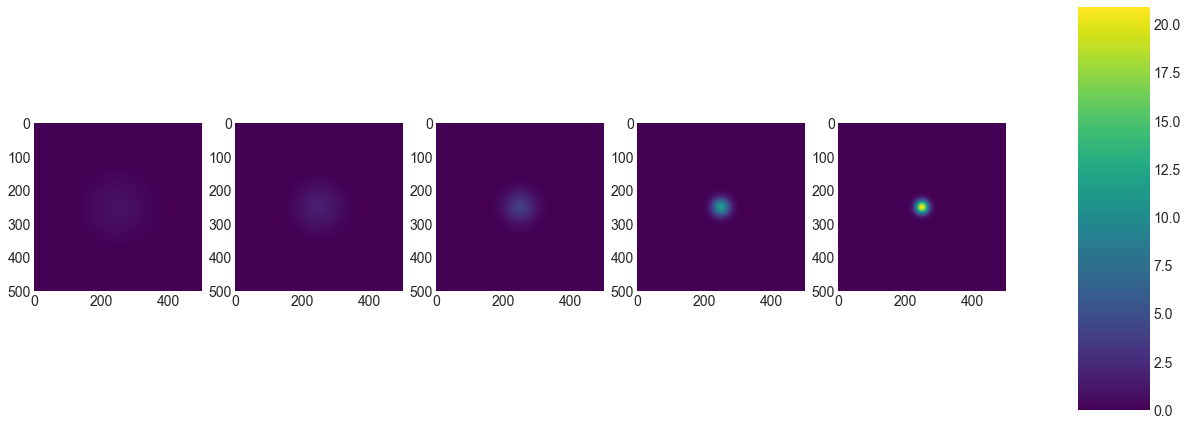

In [145]:
# Two subplots, the axes array is 1-d
f, axarr = subplots(1,5)
f.set_figwidth(20)
ma = max(abs(allData).flatten())**2
mi = min(abs(allData).flatten())**2
axarr[0].imshow(abs(field0)**2, vmin=mi, vmax=ma)
axarr[0].grid(0)
for i, ax in enumerate(axarr[1:]):
    im = ax.imshow(abs(allData[i+1])**2, vmin=mi, vmax=ma)
    ax.grid(0)
f.subplots_adjust(right=0.8)
cbar_ax = f.add_axes([0.85, 0.15, 0.05, 0.7])
f.colorbar(im, cax=cbar_ax)

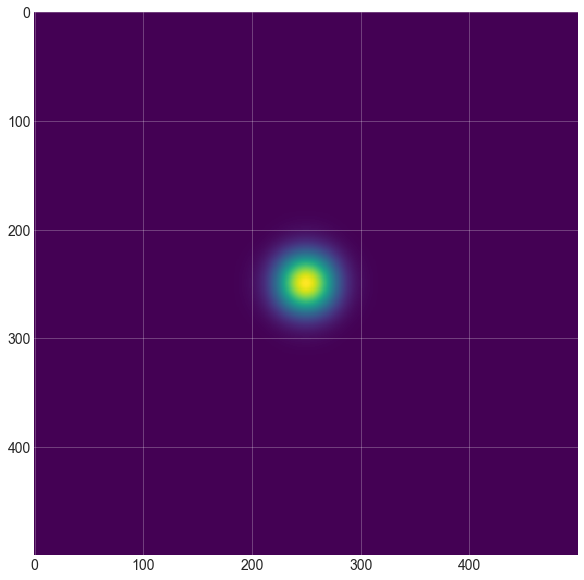

In [146]:
figure(figsize=(10,10))
imshow(abs(allData[-1]))

## Clipped Focused Gaussian Beam

In [18]:
dataComa = np.load('ComaData.npy')

In [41]:
for r in np.linspace(2,6,5):
    print(r, ':', getRadialFreqs(dataComa, r, picScale=2e-4/5001, ampScale=1e-3*mc.k_B))

Getting Intensity...


KeyboardInterrupt: 

## figuring out what density of points to use

In the end I decided it was better to just brute-force it; 5001 points. Takes like 1.5 hours per run on the main data analysis computer

In [71]:
createInteractivePlot(data_coarser2, 'Focused-Gaussian.html', scaleFactor=4)

### test

In [57]:
fieldtest = calcBaseField(1e-4, 1e-4, 1e-4, (0.96, 1.04), 501)

In [58]:
%%timeit
focusedGaussian = doPropsAroundWaist(1e-4, 1e-4, 1e-4, (0.96, 1.04), 501, 25, field0=fieldtest)

fin.
28.4 s ± 307 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [59]:
%%timeit
focusedGaussian = doPropsAroundWaist_withManyFunc(1e-4, 1e-4, 1e-4, (0.96, 1.04), 501, 25, field0=fieldtest)

Initialized.
[  9.60000000e-05   9.63333333e-05   9.66666667e-05   9.70000000e-05
   9.73333333e-05   9.76666667e-05   9.80000000e-05   9.83333333e-05
   9.86666667e-05   9.90000000e-05   9.93333333e-05   9.96666667e-05
   1.00000000e-04   1.00333333e-04   1.00666667e-04   1.01000000e-04
   1.01333333e-04   1.01666667e-04   1.02000000e-04   1.02333333e-04
   1.02666667e-04   1.03000000e-04   1.03333333e-04   1.03666667e-04
   1.04000000e-04]
fin.
Initialized.
[  9.60000000e-05   9.63333333e-05   9.66666667e-05   9.70000000e-05
   9.73333333e-05   9.76666667e-05   9.80000000e-05   9.83333333e-05
   9.86666667e-05   9.90000000e-05   9.93333333e-05   9.96666667e-05
   1.00000000e-04   1.00333333e-04   1.00666667e-04   1.01000000e-04
   1.01333333e-04   1.01666667e-04   1.02000000e-04   1.02333333e-04
   1.02666667e-04   1.03000000e-04   1.03333333e-04   1.03666667e-04
   1.04000000e-04]
fin.
Initialized.
[  9.60000000e-05   9.63333333e-05   9.66666667e-05   9.70000000e-05
   9.73333333e-0

### fin

In [23]:
np.save('Base-Field', field0)

In [42]:
field0 = np.load('Base-Field.npy')

In [ ]:
field0 = calcBaseField(1e-4, 1e-4, 1e-4, (0.96, 1.04), 5001)

In [43]:
focusedGaussian = doPropsAroundWaist(1e-4, 1e-4, 1e-4, (0.96, 1.04), 5001, 25, field0=field0)

Initializing Field...Done.
Creating Propagation #6...


KeyboardInterrupt: 

In [34]:
np.save('Focused-Gaussian-Data', focusedGaussian)

In [ ]:
createInteractivePlot(focusedGaussian, 'Focused-Gaussian-x.html', scaleFactor=8)

2.0 : (177048.34092907564, 177048.34092909249, 6.732776806866087e-06)
3.0 : (174702.12293881067, 174702.12305722517, 5.2189668157985738e-05)
4.0 : (172573.84558644882, 172573.84565566244, 9.374029594417442e-05)
5.0 : (169829.77740798501, 169829.77741576615, 0.00016615818804520673)
6.0 : (164897.90681412877, 164897.90676907141, 0.00035238279972089415)


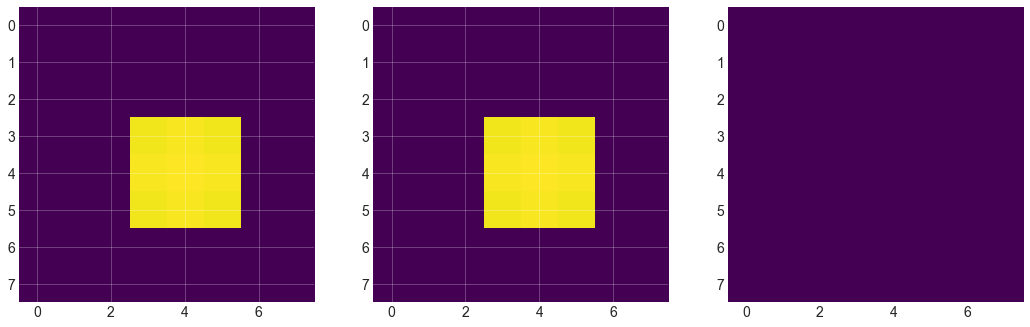

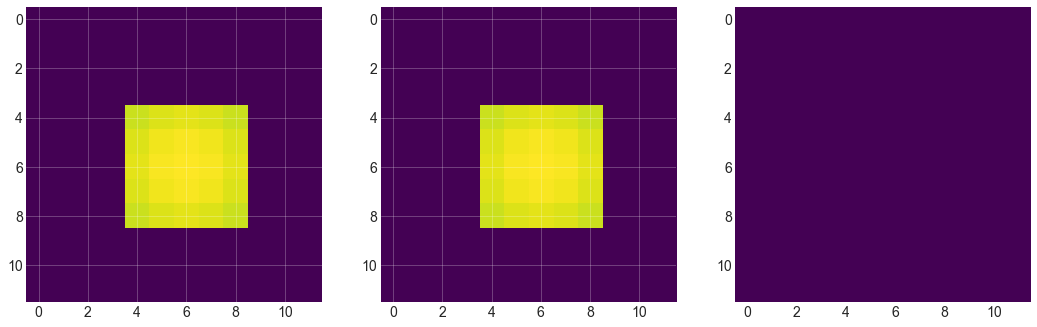

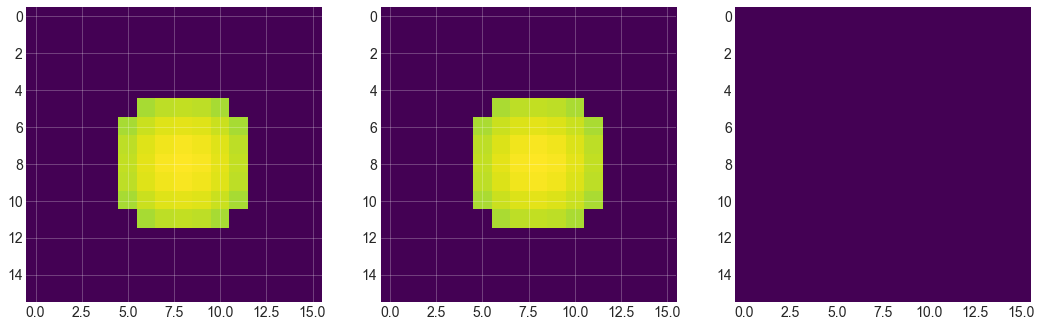

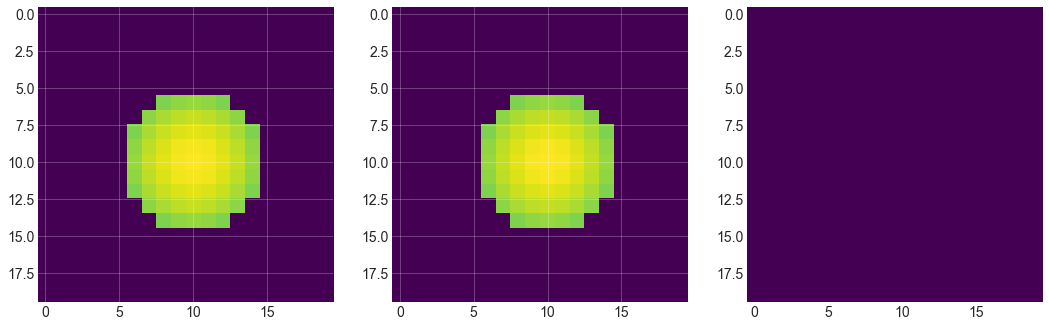

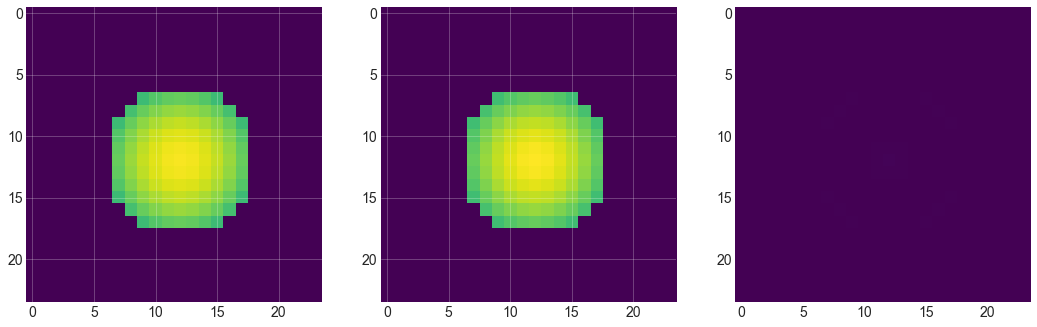

In [97]:
for r in np.linspace(2,6,5):
    print(r, ':', getRadialFreqs(data, r, picScale=2e-4/5001, ampScale=1e-3*mc.k_B))

### 2001

In [ ]:
data_coarser2 = doPropsAroundWaist(1e-4, 1e-4, 1e-4, (0.97, 1.03), 2001, 20)

2.0 : 172.462010516 kHz 172.462010577 kHz 0.000253778404673 err
3.0 : 158.701534386 kHz 158.701534386 kHz 0.00172542877092 err
4.0 : 147.00997749 kHz 147.009977479 kHz 0.00279654409073 err
5.0 : 133.102593255 kHz 133.102593268 kHz 0.00434084827435 err
6.0 : 111.369461997 kHz 111.369461999 kHz 0.00702740714986 err


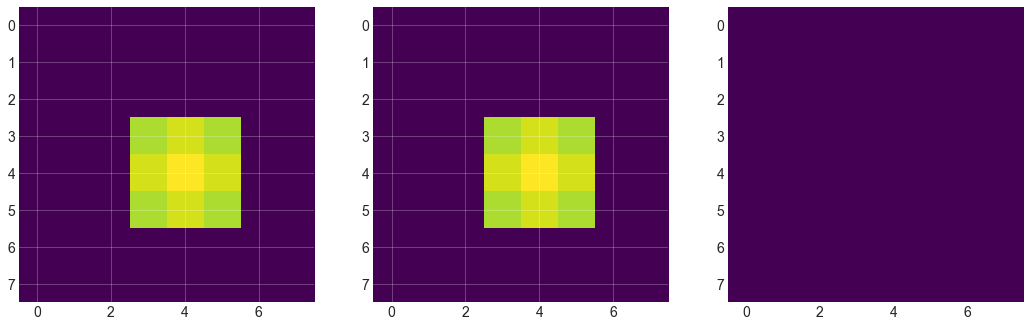

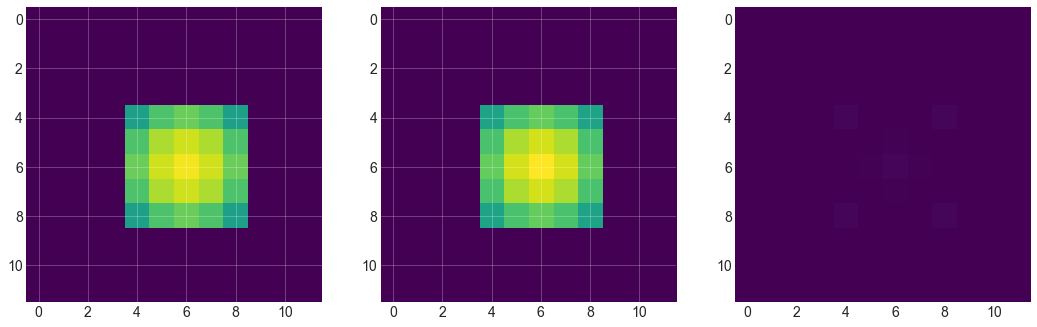

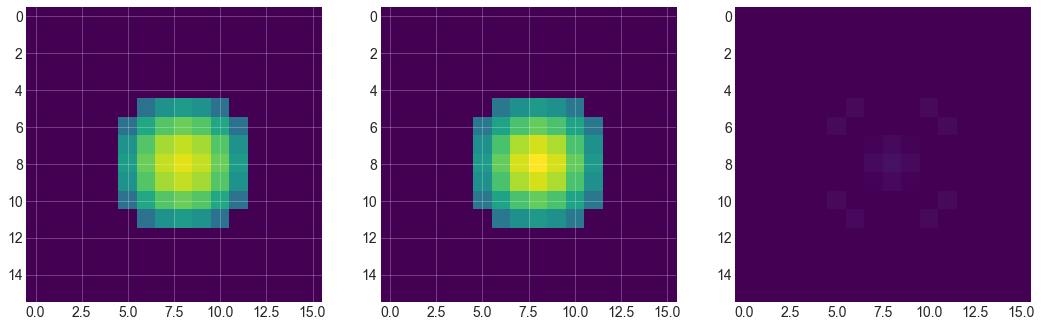

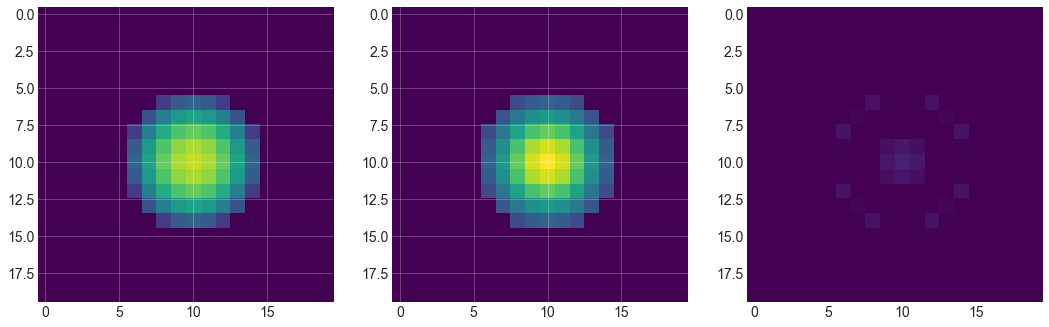

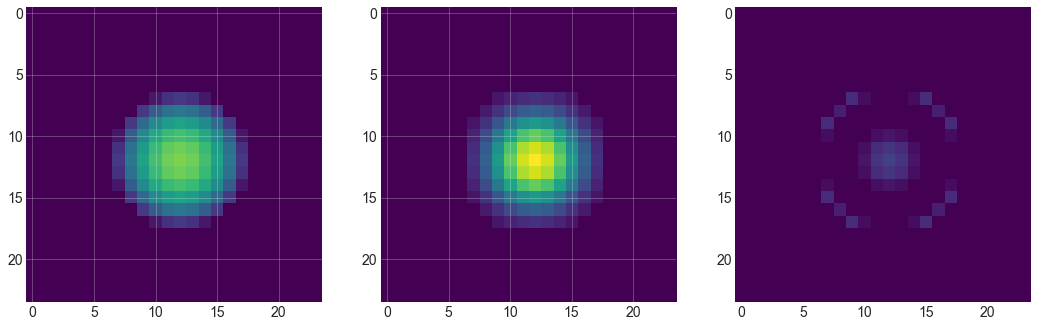

In [92]:
for r in np.linspace(2,6,5):
    res = getRadialFreqs(data_coarser2, r, picScale=2e-4/2001, ampScale=1e-3*mc.k_B)
    print(r, ':', res[0]*1e-3, 'kHz', res[1]*1e-3, 'kHz', res[2], 'err' )

### 1501

2.0 : ((123018.4109049526, 123018.41090495186), -3.344884736279446e-38)
3.0 : ((115815.70714258609, 115815.7071590844), -9.7116037187075716e-41)
4.0 : ((109483.57766947315, 109483.57766067173), 3.4645578672103284e-41)
5.0 : ((101629.00102031197, 101629.00102494677), 5.6100854596130236e-37)
6.0 : ((87669.431503283879, 87669.431534088013), 2.9346007587283922e-36)


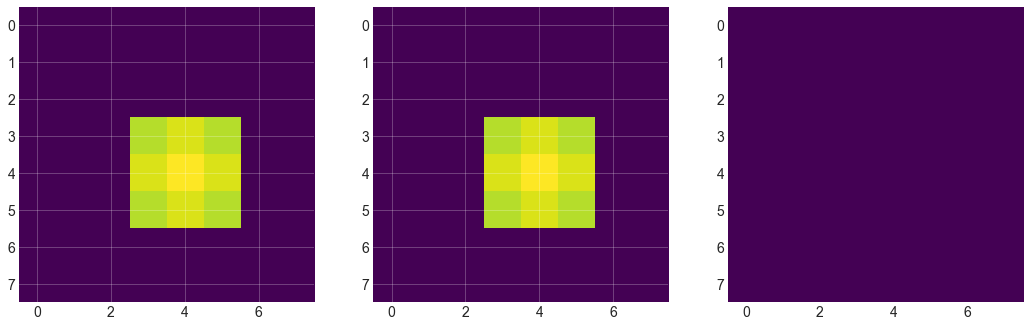

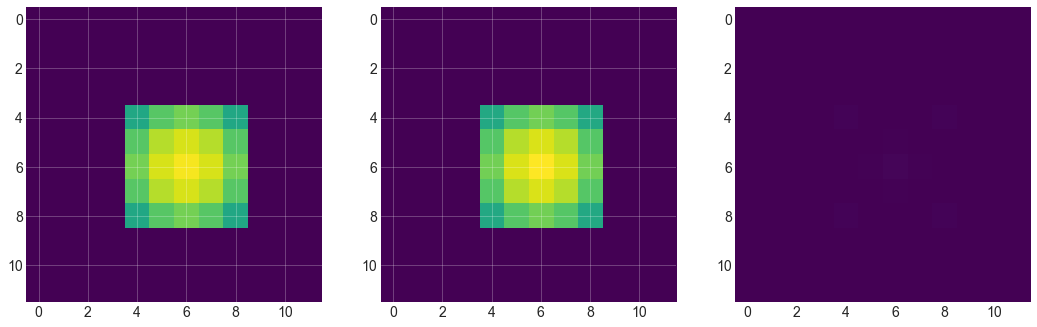

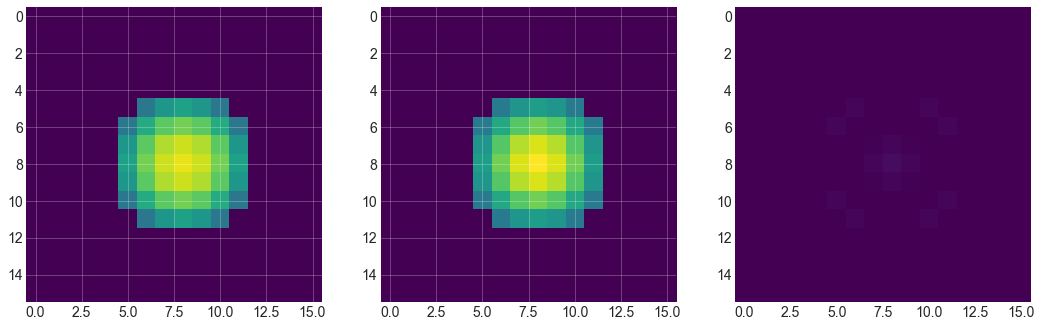

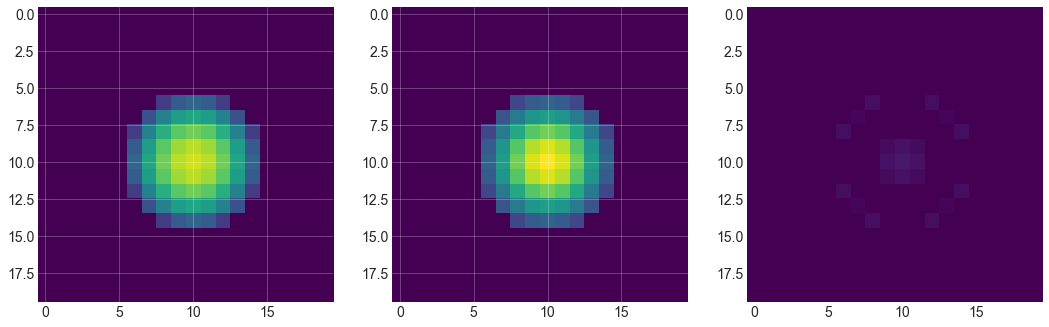

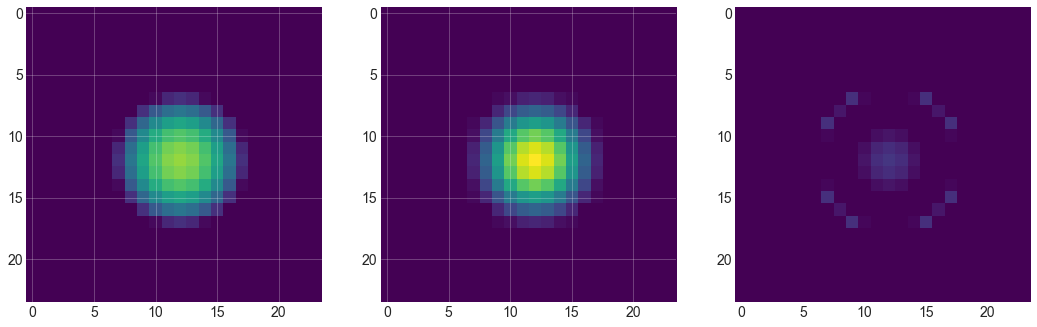

In [68]:
for r in np.linspace(2,6,5):
    print(r, ':', getRadialFreqs(data_coarser2, r, picScale=2e-4/1501, ampScale=1e-3*mc.k_B))

### 1001

In [59]:
data_coarser = doPropsAroundWaist(1e-4, 1e-4, 1e-4, (0.96, 1.04), 1001, 15)

fin.


2.0 : ((119565.38699970659, 119565.38703583798), -4.0237818303599016e-38)
3.0 : ((104246.6520767561, 104246.65198495924), 1.2053408870736346e-42)
4.0 : ((91512.731923763407, 91512.731912806092), -4.0307785870825947e-37)
5.0 : ((68531.60042012413, 68531.600432706502), 4.7035415285732948e-37)
6.0 : ((44139.66531519861, 44139.665355155274), 1.3995171440017268e-40)


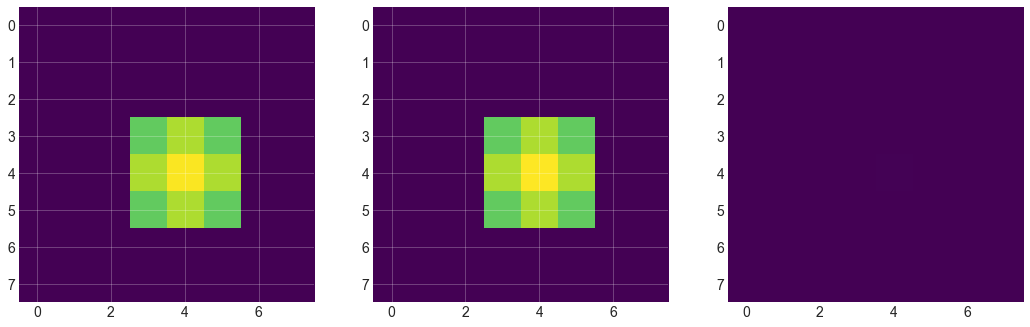

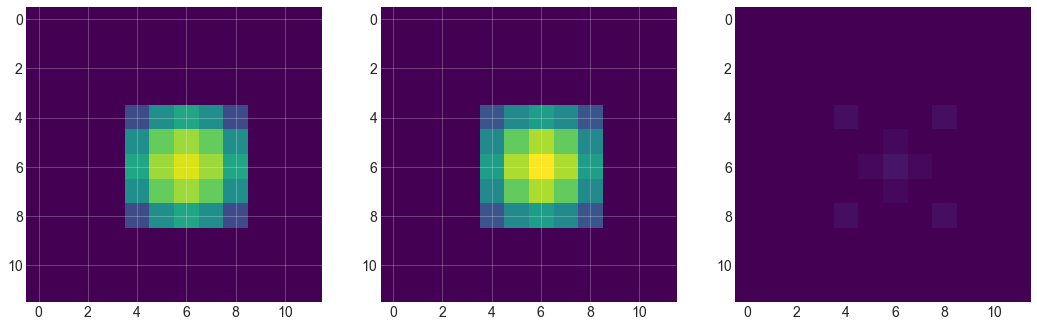

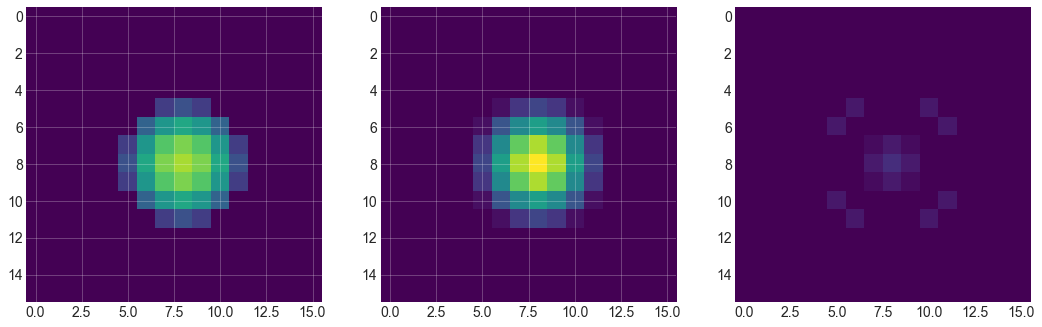

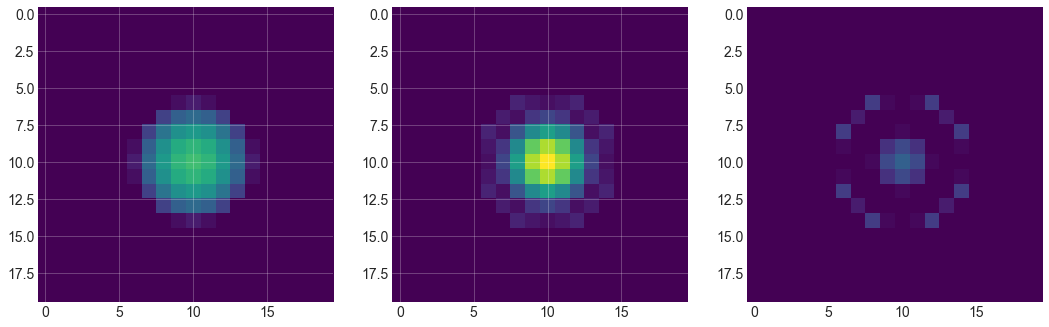

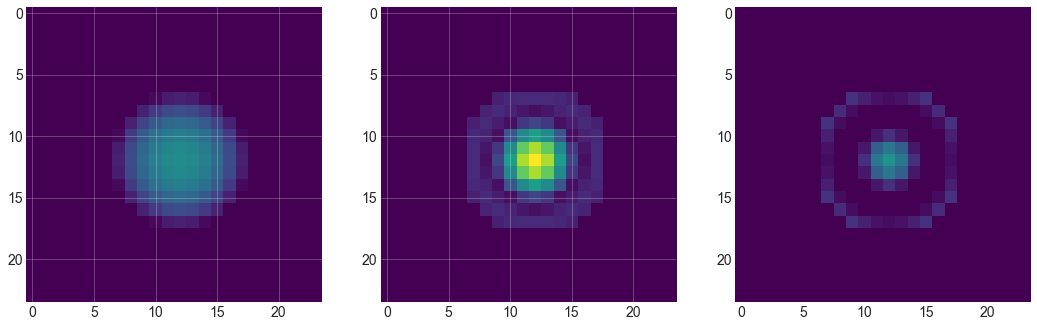

In [65]:
for r in np.linspace(2,6,5):
    print(r, ':', getRadialFreqs(data_coarser, r, picScale=2e-4/1001, ampScale=1e-3*mc.k_B))

### 3001

In [54]:
field0 = calcBaseField(1e-4, 1e-4, 1e-4, (0.96, 1.04), 3001)

Initializing Field...

In [56]:
data = doPropsAroundWaist(1e-4, 1e-4, 1e-4, (0.96, 1.04), 3001, 15, field0=field0)

fin.


2.0 : (175470.30574065406, 175470.30574064885, 5.1278590650015001e-05)
3.0 : (169096.31210463349, 169096.31214268666, 0.00038027977731478298)
4.0 : (163439.21073757848, 163439.21074955107, 0.00065961798529234547)
5.0 : (156336.50308529189, 156336.50312136565, 0.0011176424587914151)
6.0 : (144140.85473860006, 144140.85472447341, 0.0021600558964099698)


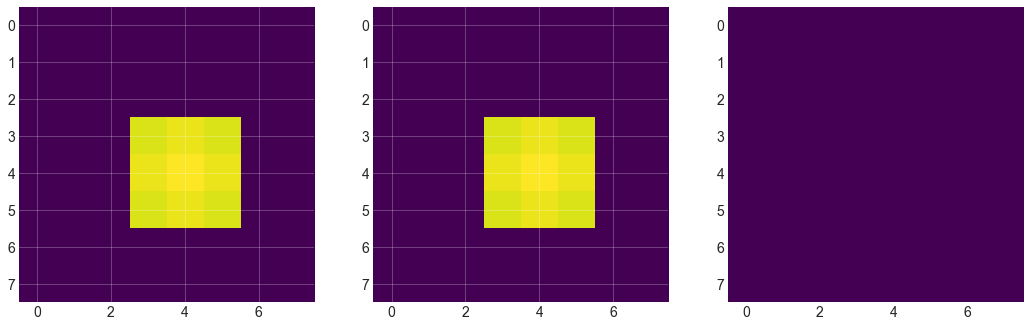

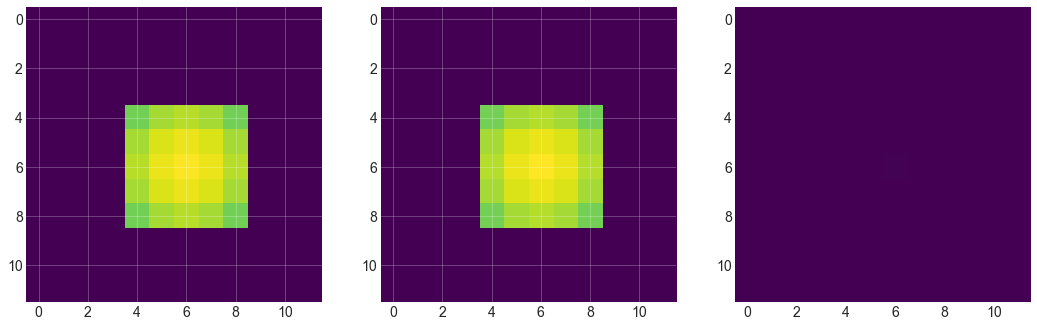

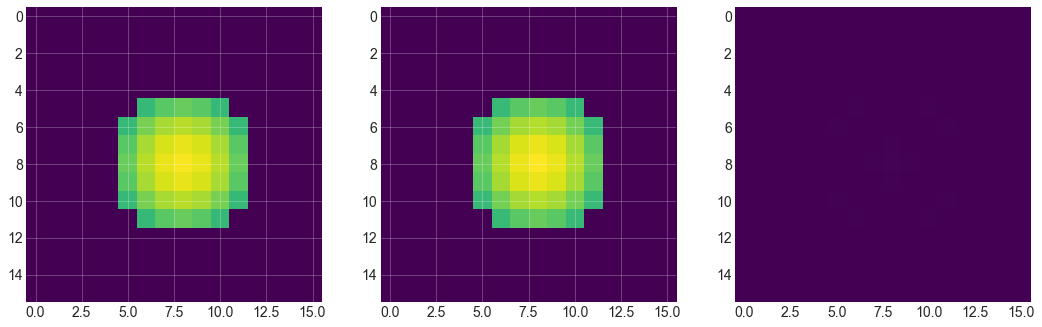

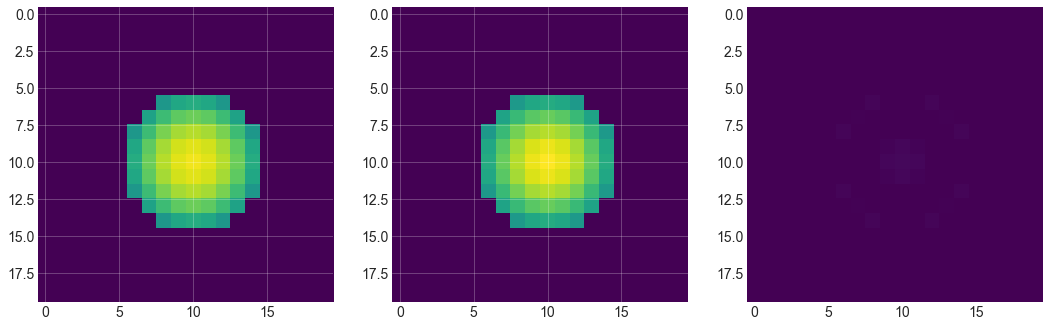

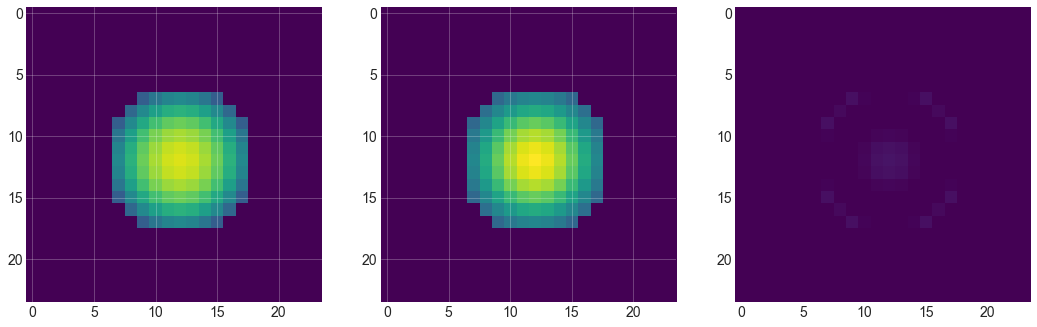

In [93]:
for r in np.linspace(2,6,5):
    print(r, ':', getRadialFreqs(data, r, picScale=2e-4/3001, ampScale=1e-3*mc.k_B))

404.89666814636013

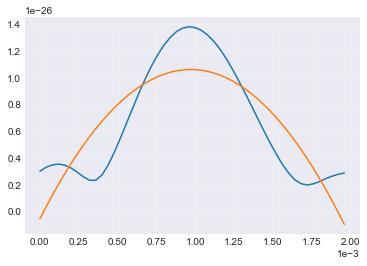

In [305]:
getAxialFreqs(data, 0, picSpacing=0.2*0.01/50, ampScale = 1e-3*mc.k_B)

# Nice plots for visualizing the abberations.

Uses low-NA config in order to have reasonable intensity throughout focusing and uses large (1 lambda) aberrations to exacperate the effect of them.

In [427]:
numPix = 2501
numPics = 151

In [388]:
field0_vis = calcBaseField(1e-4, 1e-4, 0.5e-3, numPix)

In [389]:
np.save('Visualation-Field0', field0_vis)

## Single Loop

In [5]:
import numpy as np

In [6]:
import os
import psutil

In [428]:
def complete(name, aberration, aberrationScale=0.2, logScale=False, loadName=None,
            focalLength=1e-4, focalView=(0.96, 1.04), getFreqs=True):
    print('Calculating aberration: ', name)
    if loadName is not None:
        field0 = np.load(loadName)
    else:
        field0 = calcBaseField( 1e-4, 1e-4, focalLength, 2501)
    data = doPropsAroundWaist_2( 1e-4, 1e-4, focalLength, focalView, numPix, numPics, field0=field0,
                                 aberration=aberration, aberrationScale=aberrationScale, quiet=True )
    np.save(name + '.npy', data)
    print('Aberration: ', name)
    print('Finished Propagations.')
    createInteractivePlot(data, name + '.html', scaleFactor=8, logMap=logScale)
    if not getFreqs:
        return
    depth = np.max(data.flatten())
    print('Relative Depth: ', depth)
    print('Axial-Frequency:')
    axialFreqs = []
    for r in range(2,10):
        res = getAxialFreqs(data, r, picSpacing=0.08*1e-4/numPics)
        axialFreqs.append(res)
        print(r, ':', round_sig(res*1e-3,4), 'kHz')
    print('Radial-Frequencies:')
    radialFreqs = []
    for r in range(2,6):
        res = getRadialFreqs(data, r, picScale=2e-4/numPix, ampScale=1)
        radialFreqs.append((res[0], res[1]))
        print(r, ':', round_sig(res[0]*1e-3,4), 'kHz', round_sig(res[1]*1e-3,4), 'kHz', res[2])
    return depth, radialFreqs, axialFreqs

In [341]:
allData = np.random.random((10,2001,2001))

In [391]:
def createInteractivePlot(allData, name, scaleFactor=4, logMap=False):
    """
    Creates a nice interactive bokeh plot.
    """
    reset_output()
    output_file(name, title=name)    
    xs = allData.shape[1]
    ys = allData.shape[2]
    shrunkData = allData[:,int(xs/2-xs/(2*scaleFactor)):int(xs/2+xs/(2*scaleFactor)),
                         int(ys/2-ys/(2*scaleFactor)):int(ys/2+ys/(2*scaleFactor))]
    minVal = min(shrunkData.flatten())
    maxVal = max(shrunkData.flatten())
    if logMap:
        color_mapper = LogColorMapper(palette="Viridis256", low=minVal, high=maxVal)
    else:
        color_mapper = LinearColorMapper(palette="Viridis256", low=minVal, high=maxVal)
    s = figure(x_range=(0, 10), y_range=(0, 10))
    ds = ColumnDataSource(data=dict(image=[shrunkData[0]]))
    ds2 = ColumnDataSource(data=dict(image=[shrunkData]))
    s.image(image='image', x=0, y=0, dw=10, dh=10, source=ds, 
           color_mapper=color_mapper)
    callback_which = CustomJS(args=dict(source=ds), 
                              code=
    """
        var imageLength = source.data['image'][0].length
        var offset = which.value * imageLength
        for (i = 0; i < imageLength; i++) 
        {
            source.data['image'][0][i] = allData.data['image'][0][offset+i]
        }
        source.data['image'][0][0] = 10;
        source.change.emit();
    """);
    whichSlider = Slider(start=0, end=len(shrunkData)-1, value=1, step=1, 
                         title="Which", callback=callback_which, width=550)
    callback_which.args["which"] = whichSlider
    callback_which.args["allData"] = ds2
    layout = column( s, whichSlider )
    save(layout)

In [349]:
import os
import psutil
process = psutil.Process(os.getpid())
import gc

In [415]:
print(process.memory_info().rss/1024**2, 'MB1')
gc.collect()
print(process.memory_info().rss/1024**2, 'MB1')

4553.26953125 MB1
4553.2734375 MB1


In [434]:
for m in range(0,9):
    for n in range(-m,m+1,2):
        complete('z_'+str(m) + ',' + str(n) + '_Log-Scale_0.5l', 
                 lambda x, y, waist, scale: zernike(m, n, x, y, waist, scale),
                 focalLength=0.35e-3, focalView=(0.65,1.15), getFreqs=False,
                 logScale=True, aberrationScale=0.5);
        # if I didn't manually do this (call the garbage collect), I found it easy for python to get overloaded.
        gc.collect()


Calculating aberration:  z_0,0_Log-Scale_0.5l
Initializing...Calculating Abberation Mask...Fin.
Starting Propagation...0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,fin.
Aberration:  z_0,0_Log-Scale_0.5l
Finished Propagations.
Calculating aberration:  z_1,-1_Log-Scale_0.5l
Initializing...Calculating Abberation Mask...Fin.
Starting Propagation...0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71

## Z=0

In [37]:
field0_vis = np.load('Visualation-Field0.npy')

In [38]:
dataClip_Vis = doPropsAroundWaist_2(1e-4, 1e-4, 0.5e-3, (0.5, 1.2), numPix, numPics, field0=field0_vis)

fin.


In [39]:
np.save('dataClip_Vis', dataClip_Vis)

In [14]:
dataClip_Vis = np.load('dataClip_Vis.npy')

In [15]:
createInteractivePlot(dataClip_Vis, 'dataClip_Vis.html', scaleFactor=4, logMap=True)

## Z=2

### Astigmatism

In [135]:
field0_vis = np.load('Visualation-Field0.npy')

In [136]:
dataAst = doPropsAroundWaist_2(1e-4, 1e-4, 0.5e-3, (0.5, 1.2), numPix, numPics, field0=field0_vis, 
                               aberration=astigmatism, aberrationScale=0.5 )

fin.


In [137]:
np.save('Astigmatism-Visualization', dataAst)

In [56]:
dataAst = np.load('Astigmatism-Visualization.npy')

In [ ]:
createInteractivePlot(dataAst, 'Astigmatism_vis.html', scaleFactor=4, logMap=True)

## Z=3

### Coma

In [41]:
field0_vis = np.load('Visualation-Field0.npy')

In [42]:
dataComaVis = doPropsAroundWaist_2(1e-4, 1e-4, 0.5e-3, (0.5, 1.2), numPix, numPics, field0=field0_vis, 
                                   aberration=horComa, aberrationScale=0.5 )

fin.


In [43]:
np.save('Coma-Visualization', dataComaVis)

In [54]:
dataComaVis = np.load('Coma-Visualization.npy')

In [55]:
createInteractivePlot(dataComaVis, 'Coma_vis.html', scaleFactor=4, logMap=True)

### trefoil

In [45]:
field0_vis = np.load('Visualation-Field0.npy')

In [46]:
dataTrefoilVis = doPropsAroundWaist_2(1e-4, 1e-4, 0.5e-3, (0.5, 1.2), numPix, numPics, field0=field0_vis, 
                                      aberration=trefoil, aberrationScale=0.5 )

fin.


In [47]:
np.save('Trefoil-Visualization', dataTrefoilVis)

In [51]:
dataTrefoilVis = np.load('Trefoil-Visualization.npy')

In [52]:
createInteractivePlot(dataTrefoilVis, 'Trefoil_vis.html', scaleFactor=4, logMap=True)

## Z=4

### Quadrafoil

In [49]:
field0_vis = np.load('Visualation-Field0.npy')

In [50]:
dataQuadrafoilVis = doPropsAroundWaist_2(1e-4, 1e-4, 0.5e-3, (0.5, 1.2), numPix, numPics, field0=field0_vis, 
                                      aberration=quadrafoil, aberrationScale=0.5 )

fin.


In [51]:
np.save('Quadrafoil-Visualization', dataQuadrafoilVis)

In [49]:
dataQuadrafoilVis = np.load('Quadrafoil-Visualization.npy')

In [50]:
createInteractivePlot(dataQuadrafoilVis, 'Quadrafoil_vis.html', scaleFactor=4, logMap=True)

### secondary Astimatism

In [53]:
field0_vis = np.load('Visualation-Field0.npy')

In [54]:
dataSecondaryAstigmatism = doPropsAroundWaist_2(1e-4, 1e-4, 0.5e-3, (0.5, 1.2), numPix, numPics,
                                                field0=field0_vis, aberration=secondaryAstigmatism, 
                                                aberrationScale=0.5 )

fin.


In [55]:
np.save('Secondary-Astigmatism-Visualization', dataSecondaryAstigmatism)

In [47]:
dataSecondaryAstigmatism = np.load('Secondary-Astigmatism-Visualization.npy')

In [48]:
createInteractivePlot(dataSecondaryAstigmatism, 'Secondary_Astigmatism_Vis.html', scaleFactor=4, logMap=True)

### Primary Spherical Aberration

In [30]:
field0_vis = np.load('Visualation-Field0.npy')

In [31]:
dataPrimarySpherical_Vis = doPropsAroundWaist_2(1e-4, 1e-4, 0.5e-3, (0.5, 1.2), numPix, numPics,
                                                field0=field0_vis, aberration=primarySpherical, 
                                                aberrationScale=0.5 )

fin.


In [32]:
np.save('Primary-Spherical-Visualization', dataPrimarySpherical_Vis)

In [45]:
dataPrimarySpherical_Vis = np.load('Primary-Spherical-Visualization.npy')

In [46]:
createInteractivePlot(dataPrimarySpherical_Vis, 'Primary_Spherical_Vis.html', scaleFactor=4, logMap=True)

## Z=5

# Systematic Aberration Analysis

## Z=0, 1

In [553]:
numPix = 2001
numPics = 49

In [554]:
field0 = calcBaseField(1e-4, 1e-4, 1e-4, numPix)

In [520]:
np.save('Field0', field0)

In [543]:
field0 = np.load('Field0.npy')

In [555]:
dataClip = doPropsAroundWaist_2( 1e-4, 1e-4, 1e-4, (0.96, 1.04), numPix, numPics, field0=field0)

fin.


In [556]:
print(np.max(dataClip.flatten()))

0.999999999998


In [557]:
for r in range(2,10):
    res = getAxialFreqs(dataClip, r, picSpacing=0.08*1e-4/numPics)
    print(r, ':', round_sig(res*1e-3,4), 'kHz')

2 : 42.88 kHz
3 : 42.45 kHz
4 : 41.86 kHz
5 : 41.13 kHz
6 : 40.27 kHz
7 : 39.27 kHz
8 : 38.17 kHz
9 : 36.98 kHz


1.3806488e-26
2 : 172.4 kHz 172.4 kHz 0.000252889958569
1.3806488e-26
3 : 158.7 kHz 158.7 kHz 0.0017203757227
1.3806488e-26
4 : 147.0 kHz 147.0 kHz 0.00278905418075
1.3806488e-26
5 : 133.1 kHz 133.1 kHz 0.00433123387037


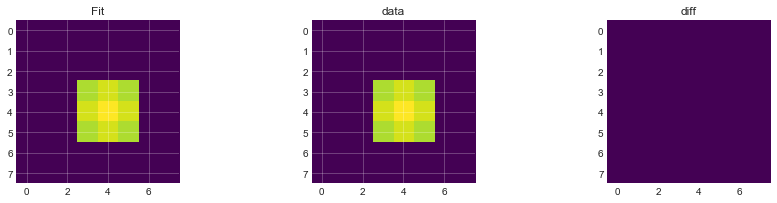

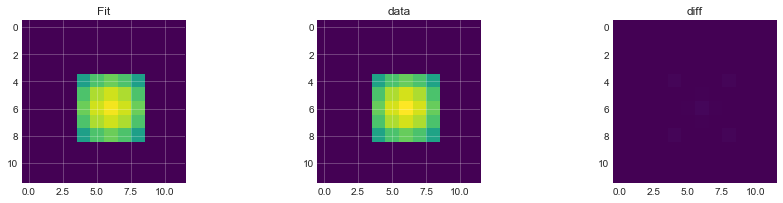

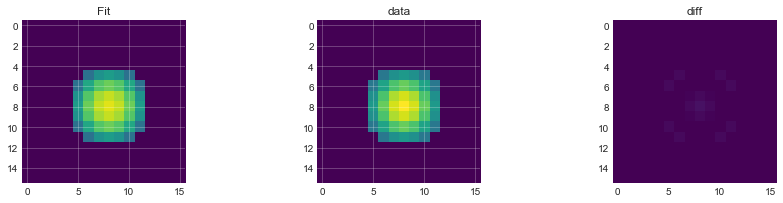

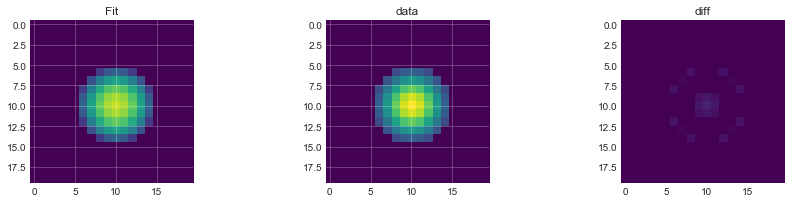

In [558]:
for r in range(2,6):
    res = getRadialFreqs(dataClip, r, picScale=2e-4/numPix, ampScale=1)
    print(r, ':', round_sig(res[0]*1e-3,4), 'kHz', round_sig(res[1]*1e-3,4), 'kHz', res[2])

## Z=2

In [300]:
from copy import deepcopy

### Astigmatism

In [563]:
field0 = np.load('Field0.npy')

In [564]:
dataAst = doPropsAroundWaist_2( 1e-4, 1e-4, 1e-4, (0.96, 1.04), numPix, numPics, field0=field0, 
                                aberration=astigmatism, aberrationScale=0.2 )


fin.


In [565]:
print('Relative Depth: ', np.max(dataAst.flatten()))

Relative Depth:  0.737675895872


In [282]:
np.save("AstigmatismData", dataAst)

In [566]:
createInteractivePlot(dataAst, 'Astigmatism.html', scaleFactor=16)

In [313]:
from Miscellaneous import round_sig

In [568]:
for r in range(2,10):
    res = getAxialFreqs(dataAst, r, picSpacing=0.08*1e-4/numPics)
    print(r, ':', round_sig(res*1e-3,4), 'kHz')

2 : 34.43 kHz
3 : 34.09 kHz
4 : 33.64 kHz
5 : 33.09 kHz
6 : 32.45 kHz
7 : 31.72 kHz
8 : 30.91 kHz
9 : 30.03 kHz


1.01847134043e-26
2 : 140.8 kHz 140.4 kHz 0.000192910157519
1.01847134043e-26
3 : 130.3 kHz 129.8 kHz 0.00134353197125
1.01847134043e-26
4 : 120.9 kHz 120.6 kHz 0.00226041736453
1.01847134043e-26
5 : 109.8 kHz 109.5 kHz 0.00374023602965


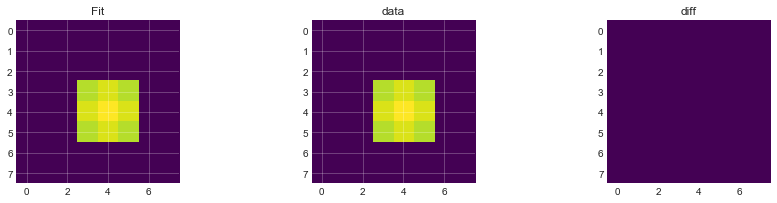

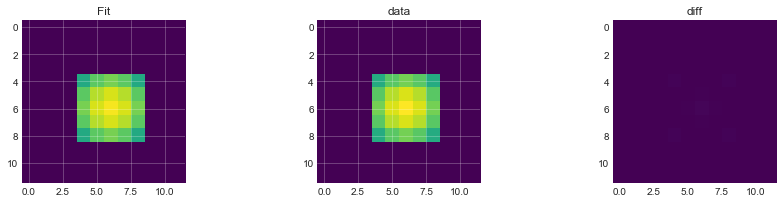

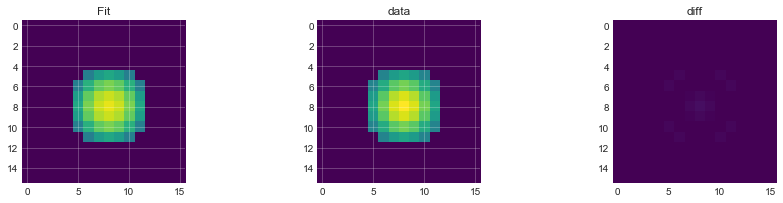

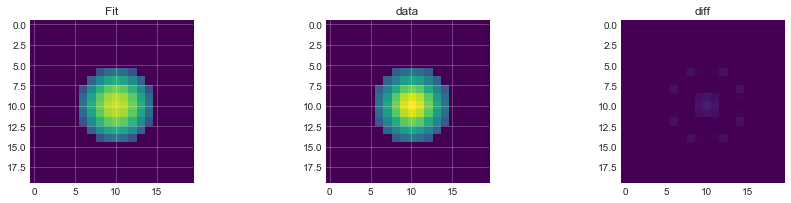

In [567]:
for r in range(2,6):
    res = getRadialFreqs(dataAst, r, picScale=2e-4/2001, ampScale=1)
    print(r, ':', round_sig(res[0]*1e-3,4), 'kHz', round_sig(res[1]*1e-3,4), 'kHz', res[2])

### Defocus

In [101]:
data = doPropsAroundWaist(0.5e-3, 0.5e-3, 0.01, (0.9, 1.1), 1000, 20, aberration=defocus)

fin.


In [102]:
createInteractivePlot(data, 'Defocus.html', scaleFactor=4)

## Z=3

### Coma

In [571]:
field0 = np.load('Field0.npy')

In [28]:
np.save('ComaData', dataComa)

In [572]:
dataComa = doPropsAroundWaist_2( 1e-4, 1e-4, 1e-4, (0.96, 1.04), numPix, numPics, field0=field0, 
                                 aberration=horComa, aberrationScale=0.2 )

fin.


In [573]:
print('Relative Depth: ', np.max(dataComa.flatten()))

Relative Depth:  0.686063691741


In [576]:
createInteractivePlot(dataComa, 'Coma.html', scaleFactor=16)

In [574]:
for r in range(2,10):
    res = getAxialFreqs(dataComa, r, picSpacing=0.08*1e-4/numPics)
    print(r, ':', round_sig(res*1e-3,4), 'kHz')

2 : 30.37 kHz
3 : 30.14 kHz
4 : 29.84 kHz
5 : 29.47 kHz
6 : 29.02 kHz
7 : 28.51 kHz
8 : 27.93 kHz
9 : 27.3 kHz


9.47213012725e-27
2 : 122.6 kHz 145.5 kHz 0.000618373946905
9.47213012725e-27
3 : 114.4 kHz 135.0 kHz 0.00230650377959
9.47213012725e-27
4 : 108.1 kHz 125.2 kHz 0.0032213996652
9.47213012725e-27
5 : 100.1 kHz 113.6 kHz 0.00444758581151


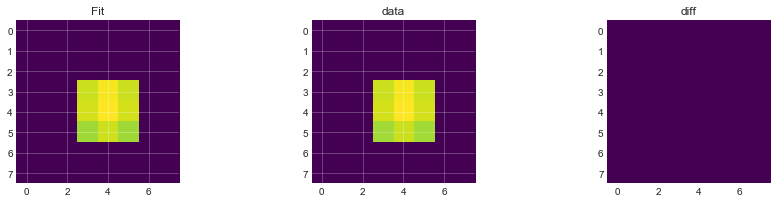

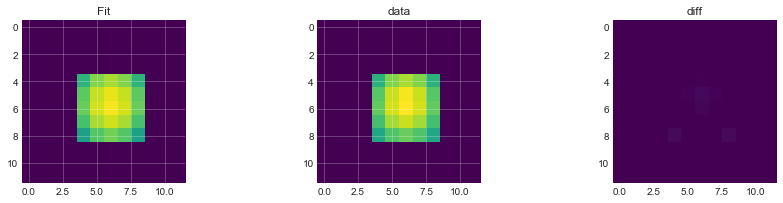

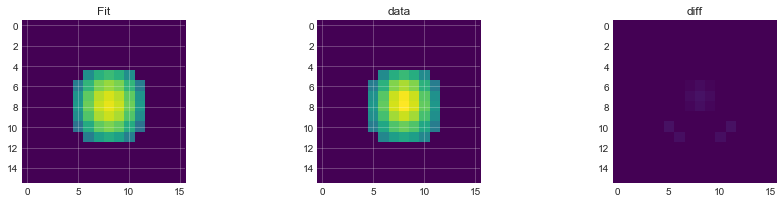

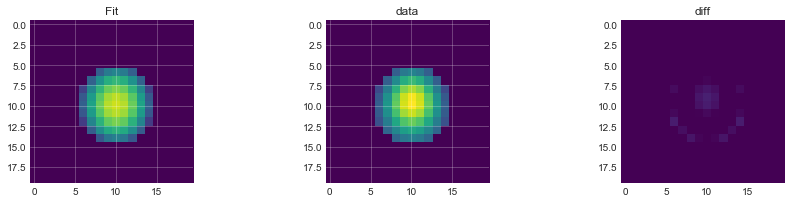

In [575]:
for r in range(2,6):
    res = getRadialFreqs(dataComa, r, picScale=2e-4/2001, ampScale=1)
    print(r, ':', round_sig(res[0]*1e-3,4), 'kHz', round_sig(res[1]*1e-3,4), 'kHz', res[2])

### Trefoil

In [649]:
field0 = np.load('Field0.npy')

In [650]:
dataTrefoil = doPropsAroundWaist_2( 1e-4, 1e-4, 1e-4, (0.96, 1.04), numPix, numPics, field0=field0, 
                                    aberration=trefoil, aberrationScale=0.2 )

fin.


In [651]:
print('Relative Depth: ', np.max(dataTrefoil.flatten()))

Relative Depth:  0.766191214461


In [652]:
for r in range(1,10):
    res = getAxialFreqs(dataTrefoil, r, picSpacing=0.08*1e-4/numPics)
    print(r, ':', round_sig(res*1e-3,4), 'kHz')

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:785: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


1 : 34.5 kHz
2 : 34.29 kHz
3 : 33.98 kHz
4 : 33.56 kHz
5 : 33.05 kHz
6 : 32.45 kHz
7 : 31.76 kHz
8 : 30.99 kHz
9 : 30.15 kHz


1.05784098082e-26
2 : 143.1 kHz 143.2 kHz 0.000713913325239
1.05784098082e-26
3 : 132.8 kHz 132.8 kHz 0.0025468379175
1.05784098082e-26
4 : 123.9 kHz 124.0 kHz 0.00397311845257
1.05784098082e-26
5 : 113.2 kHz 113.3 kHz 0.00530984443582


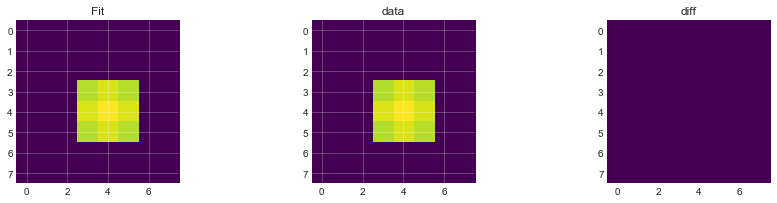

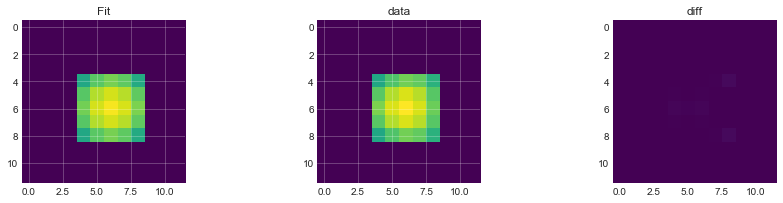

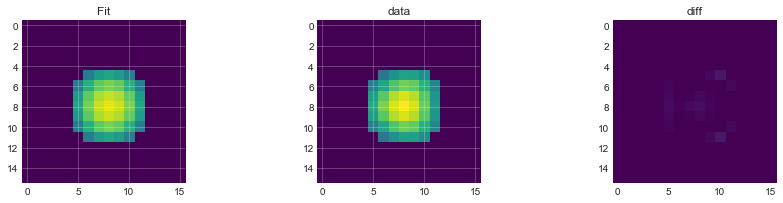

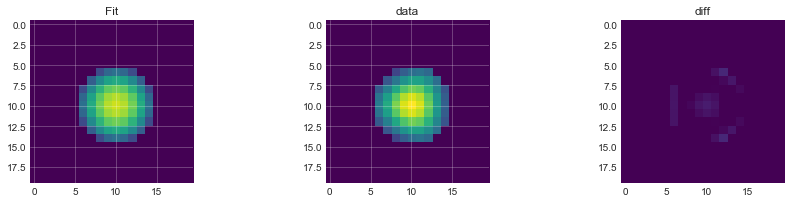

In [653]:
for r in range(2,6):
    res = getRadialFreqs(dataTrefoil, r, picScale=2e-4/2001, ampScale=1)
    print(r, ':', round_sig(res[0]*1e-3,4), 'kHz', round_sig(res[1]*1e-3,4), 'kHz', res[2])

In [124]:
np.save('TrefoilData', dataTrefoil)

In [585]:
createInteractivePlot(dataTrefoil, 'Trefoil.html', scaleFactor=16)

## Z=4

### Quadrafoil

In [591]:
field0 = np.load('Field0.npy')

In [592]:
dataQuadrafoil = doPropsAroundWaist_2( 1e-4, 1e-4, 1e-4, (0.96, 1.04), numPix, numPics, field0=field0, 
                                       aberration=quadrafoil, aberrationScale=0.2 )

fin.


In [593]:
print('Relative Depth: ', np.max(dataQuadrafoil.flatten()))

Relative Depth:  0.785823008153


In [594]:
createInteractivePlot(dataQuadrafoil, 'Quadrafoil.html', scaleFactor=16)

In [595]:
for r in range(2,10):
    res = getAxialFreqs(dataQuadrafoil, r, picSpacing=0.08*1e-4/numPics)
    print(r, ':', round_sig(res*1e-3,4), 'kHz')

2 : 34.49 kHz
3 : 34.14 kHz
4 : 33.69 kHz
5 : 33.16 kHz
6 : 32.55 kHz
7 : 31.86 kHz
8 : 31.11 kHz
9 : 30.29 kHz


1.08494559322e-26
2 : 145.1 kHz 145.6 kHz 0.000221931160219
1.08494559322e-26
3 : 134.7 kHz 135.0 kHz 0.00141306224713
1.08494559322e-26
4 : 125.8 kHz 125.8 kHz 0.00231591946616
1.08494559322e-26
5 : 115.0 kHz 115.1 kHz 0.00365631332271


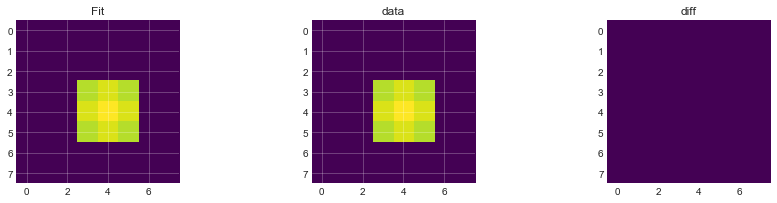

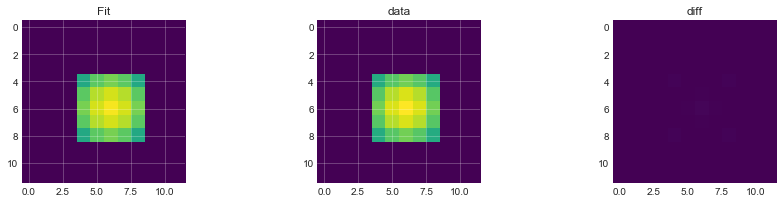

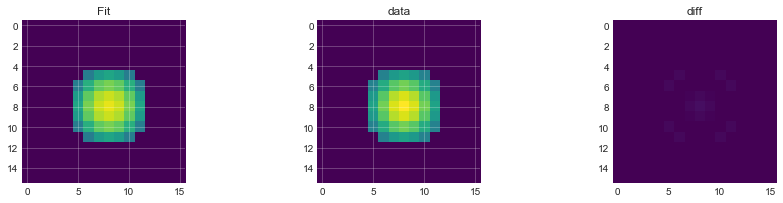

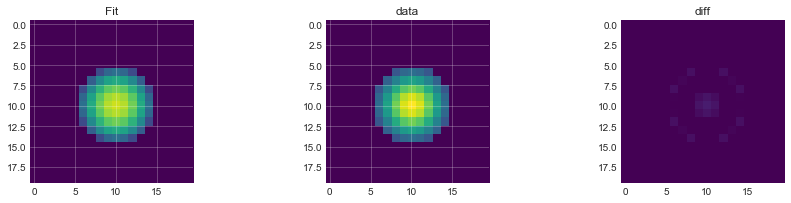

In [596]:
for r in range(2,6):
    res = getRadialFreqs(dataQuadrafoil, r, picScale=2e-4/2001, ampScale=1)
    print(r, ':', round_sig(res[0]*1e-3,4), 'kHz', round_sig(res[1]*1e-3,4), 'kHz', res[2])

### Primary Spherical

In [599]:
field0 = np.load('Field0.npy')

In [600]:
dataSpherical = doPropsAroundWaist_2( 1e-4, 1e-4, 1e-4, (0.96, 1.04), numPix, numPics, field0=field0, 
                                      aberration=primarySpherical, aberrationScale=0.2 )

fin.


In [601]:
print('Relative Depth: ', np.max(dataSpherical.flatten()))

Relative Depth:  0.681172642253


In [602]:
createInteractivePlot(dataSpherical, 'Primary-Sherical.html', scaleFactor=16)

In [603]:
for r in range(2,10):
    res = getAxialFreqs(dataSpherical, r, picSpacing=0.08*1e-4/numPics)
    print(r, ':', round_sig(res*1e-3,4), 'kHz')

2 : 27.2 kHz
3 : 26.83 kHz
4 : 26.35 kHz
5 : 25.78 kHz
6 : 25.12 kHz
7 : 24.39 kHz
8 : 23.59 kHz
9 : 22.74 kHz


9.40460191119e-27
2 : 134.6 kHz 134.6 kHz 0.000199876025589
9.40460191119e-27
3 : 125.0 kHz 125.0 kHz 0.00138499245878
9.40460191119e-27
4 : 117.1 kHz 116.9 kHz 0.00227998959021
9.40460191119e-27
5 : 107.0 kHz 107.1 kHz 0.00360511060954


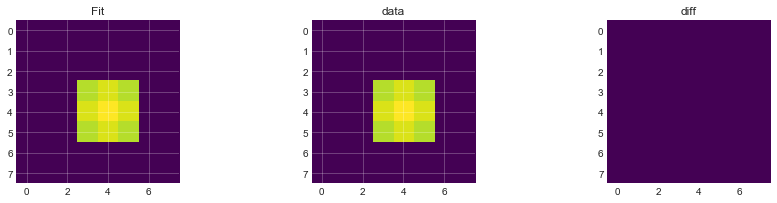

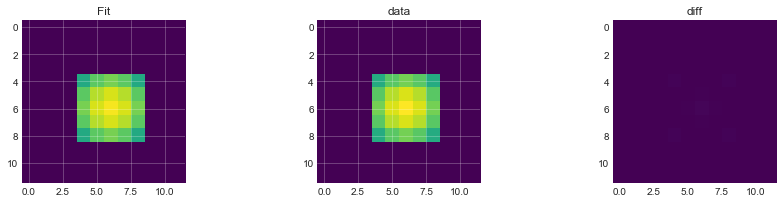

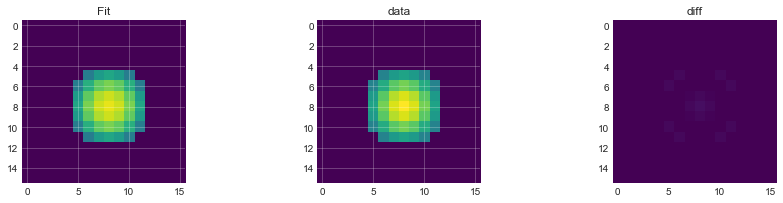

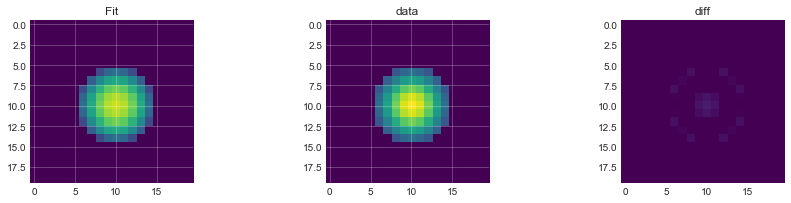

In [604]:
for r in range(2,6):
    res = getRadialFreqs(dataSpherical, r, picScale=2e-4/2001, ampScale=1)
    print(r, ':', round_sig(res[0]*1e-3,4), 'kHz', round_sig(res[1]*1e-3,4), 'kHz', res[2])

### Secondary Astigmatism

In [606]:
field0 = np.load('Field0.npy')

In [607]:
dataSecondaryAstigmatism = doPropsAroundWaist_2( 1e-4, 1e-4, 1e-4, (0.96, 1.04), numPix, numPics, field0=field0,
                                                  aberration=secondaryAstigmatism, aberrationScale=0.2 )

fin.


In [608]:
print('Relative Depth: ', np.max(dataSecondaryAstigmatism.flatten()))

Relative Depth:  0.64252761498


In [609]:
createInteractivePlot(dataSecondaryAstigmatism, 'Secondary-Astigmatism.html', scaleFactor=16)

In [610]:
for r in range(2,10):
    res = getAxialFreqs(dataSecondaryAstigmatism, r, picSpacing=0.08*1e-4/numPics)
    print(r, ':', round_sig(res*1e-3,4), 'kHz')

2 : 35.17 kHz
3 : 34.77 kHz
4 : 34.25 kHz
5 : 33.61 kHz
6 : 32.88 kHz
7 : 32.05 kHz
8 : 31.13 kHz
9 : 30.13 kHz


8.87104980589e-27
2 : 134.9 kHz 135.0 kHz 0.00023666802603
8.87104980589e-27
3 : 124.3 kHz 124.5 kHz 0.00160296764247
8.87104980589e-27
4 : 115.2 kHz 115.4 kHz 0.00259884025466
8.87104980589e-27
5 : 104.3 kHz 104.5 kHz 0.00408911703928


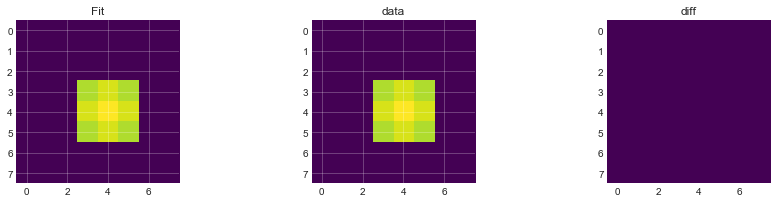

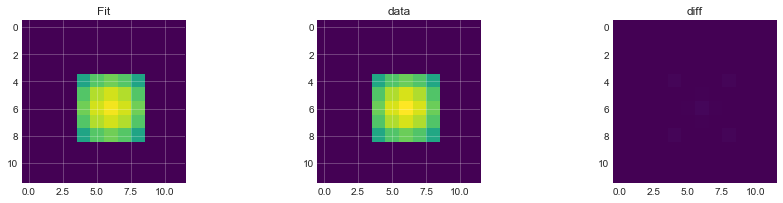

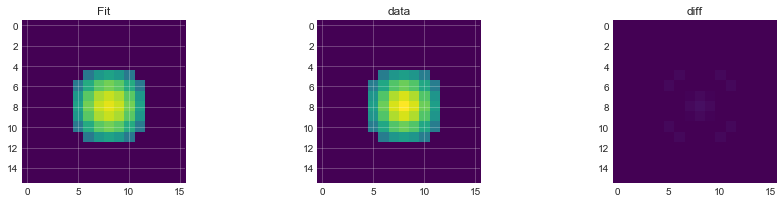

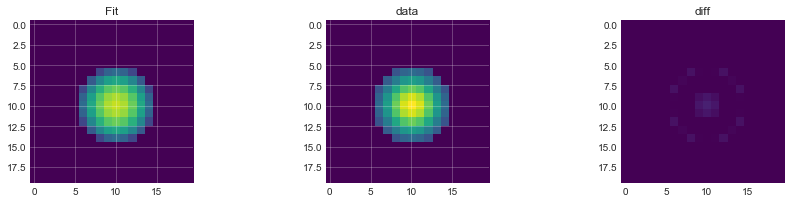

In [612]:
for r in range(2,6):
    res = getRadialFreqs(dataSecondaryAstigmatism, r, picScale=2e-4/numPix, ampScale=1)
    print(r, ':', round_sig(res[0]*1e-3,4), 'kHz', round_sig(res[1]*1e-3,4), 'kHz', res[2])

## Z=5

### 5,1, secondary coma

In [668]:
field0 = np.load('Field0.npy')

In [672]:
dataSecondaryComa = doPropsAroundWaist_2( 1e-4, 1e-4, 1e-4, (0.96, 1.04), numPix, numPics, field0=field0,
                                         aberration=secondaryComa, aberrationScale=0.2 )

fin.


In [673]:
print('Relative Depth: ', np.max(dataSecondaryComa.flatten()))

Relative Depth:  0.587366239919


In [684]:
createInteractivePlot(dataSecondaryComa, 'Secondary-Coma.html', scaleFactor=16)

In [675]:
for r in range(2,10):
    res = getAxialFreqs(dataSecondaryComa, r, picSpacing=0.08*1e-4/numPics)
    print(r, ':', round_sig(res*1e-3,4), 'kHz')

2 : 31.72 kHz
3 : 31.4 kHz
4 : 30.98 kHz
5 : 30.46 kHz
6 : 29.85 kHz
7 : 29.15 kHz
8 : 28.38 kHz
9 : 27.54 kHz


8.10946494304e-27
2 : 125.5 kHz 142.7 kHz 0.000271326890979
8.10946494304e-27
3 : 115.0 kHz 131.0 kHz 0.00184755292045
8.10946494304e-27
4 : 106.8 kHz 120.4 kHz 0.00304903918494
8.10946494304e-27
5 : 96.71 kHz 108.0 kHz 0.0047940777976


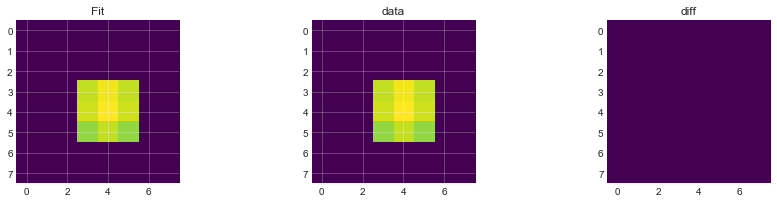

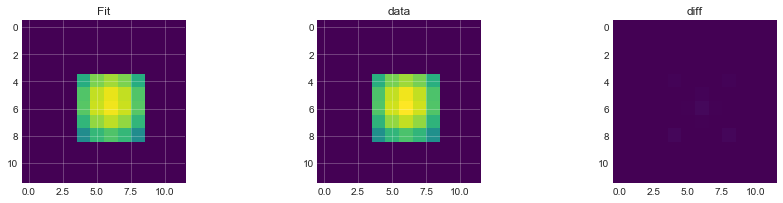

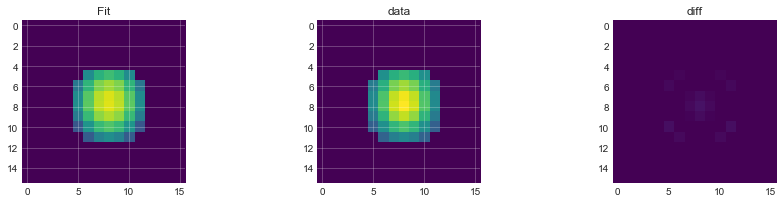

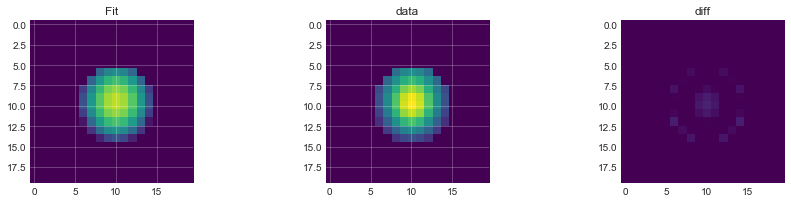

In [676]:
for r in range(2,6):
    res = getRadialFreqs(dataSecondaryComa, r, picScale=2e-4/numPix, ampScale=1)
    print(r, ':', round_sig(res[0]*1e-3,4), 'kHz', round_sig(res[1]*1e-3,4), 'kHz', res[2])

### 5,3 Secondary Trefoil

In [677]:
field0 = np.load('Field0.npy')

In [678]:
dataZ_53 = doPropsAroundWaist_2( 1e-4, 1e-4, 1e-4, (0.96, 1.04), numPix, numPics, field0=field0,
                                         aberration=Z_53, aberrationScale=0.2 )

fin.


In [679]:
print('Relative Depth: ', np.max(dataZ_53.flatten()))

Relative Depth:  0.676404338098


In [683]:
createInteractivePlot(dataZ_53, 'Secondary-Trefoil.html', scaleFactor=16)

In [680]:
for r in range(2,10):
    res = getAxialFreqs(dataZ_53, r, picSpacing=0.08*1e-4/numPics)
    print(r, ':', round_sig(res*1e-3,4), 'kHz')

2 : 35.48 kHz
3 : 35.1 kHz
4 : 34.59 kHz
5 : 33.98 kHz
6 : 33.25 kHz
7 : 32.42 kHz
8 : 31.5 kHz
9 : 30.5 kHz


9.33876837709e-27
2 : 136.6 kHz 136.6 kHz 0.000488126370674
9.33876837709e-27
3 : 126.0 kHz 126.1 kHz 0.00215130110223
9.33876837709e-27
4 : 117.6 kHz 117.5 kHz 0.00326530627194
9.33876837709e-27
5 : 107.2 kHz 107.0 kHz 0.00466343464999


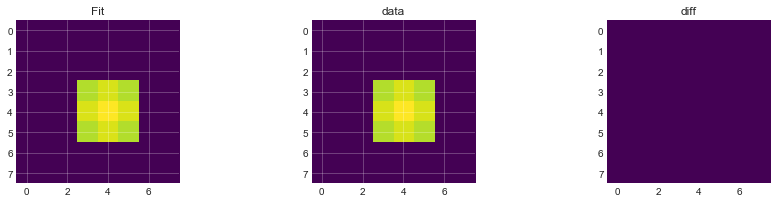

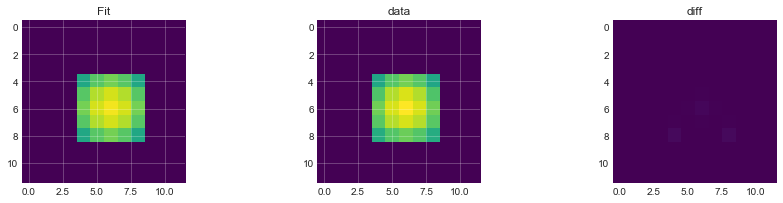

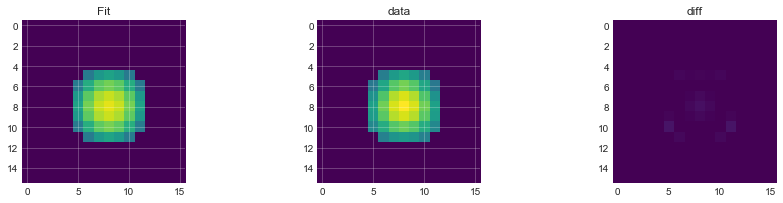

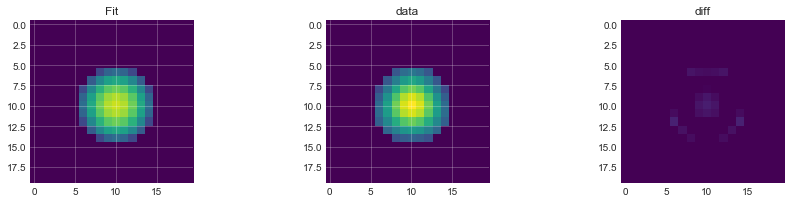

In [681]:
for r in range(2,6):
    res = getRadialFreqs(dataZ_53, r, picScale=2e-4/numPix, ampScale=1)
    print(r, ':', round_sig(res[0]*1e-3,4), 'kHz', round_sig(res[1]*1e-3,4), 'kHz', res[2])

### 5,5 quinta foil

In [693]:
field0 = np.load('Field0.npy')

In [694]:
dataQuint = doPropsAroundWaist_2(1e-4, 1e-4, 1e-4, (0.96, 1.04), numPix, numPics, field0=field0,
                                 aberration=quintaFoil, aberrationScale=0.2 )

fin.


In [695]:
print('Relative Depth: ', np.max(dataQuint.flatten()))

Relative Depth:  0.799823050229


In [696]:
createInteractivePlot(dataQuint, 'Quinta-Foil.html', scaleFactor=16)

In [697]:
for r in range(2,10):
    res = getAxialFreqs(dataQuint, r, picSpacing=0.08*1e-4/numPics)
    print(r, ':', round_sig(res*1e-3,4), 'kHz')

2 : 34.43 kHz
3 : 34.13 kHz
4 : 33.73 kHz
5 : 33.24 kHz
6 : 32.66 kHz
7 : 32.0 kHz
8 : 31.26 kHz
9 : 30.46 kHz


1.10427473451e-26
2 : 146.6 kHz 146.6 kHz 0.000205384284643
1.10427473451e-26
3 : 136.0 kHz 136.1 kHz 0.0014192249964
1.10427473451e-26
4 : 127.0 kHz 127.0 kHz 0.00232890729419
1.10427473451e-26
5 : 116.1 kHz 116.1 kHz 0.00367336409542


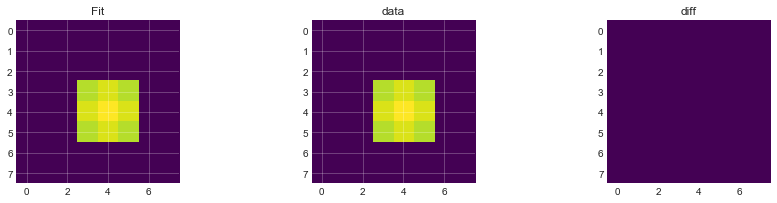

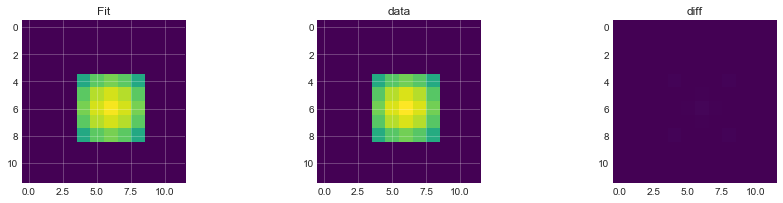

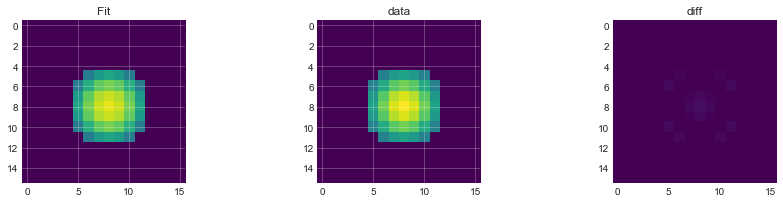

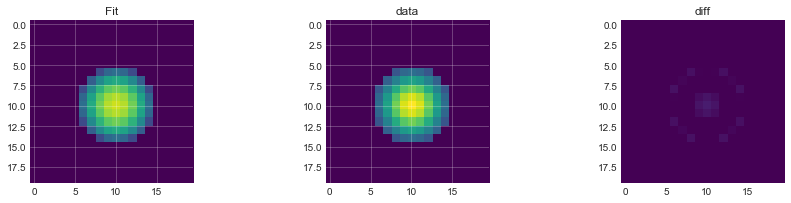

In [698]:
for r in range(2,6):
    res = getRadialFreqs(dataQuint, r, picScale=2e-4/numPix, ampScale=1)
    print(r, ':', round_sig(res[0]*1e-3,4), 'kHz', round_sig(res[1]*1e-3,4), 'kHz', res[2])

## Z=6

### Spherical-2

fin.
Relative Depth:  0.57812749102
Axial-Frequency:
2 : 29.88 kHz
3 : 29.55 kHz
4 : 29.12 kHz
5 : 28.61 kHz
6 : 28.02 kHz
7 : 27.35 kHz
8 : 26.61 kHz
9 : 25.79 kHz
Radial-Frequencies:
7.98191026724e-27
2 : 134.6 kHz 134.8 kHz 0.000501940980074
7.98191026724e-27
3 : 122.4 kHz 122.4 kHz 0.00180210424297
7.98191026724e-27
4 : 113.3 kHz 113.4 kHz 0.00292536922744
7.98191026724e-27
5 : 102.3 kHz 102.3 kHz 0.00454264798828


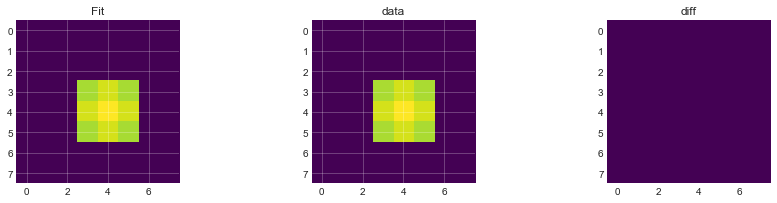

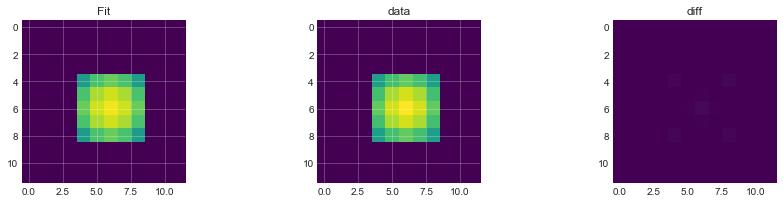

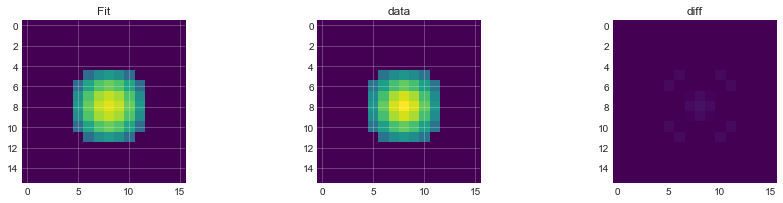

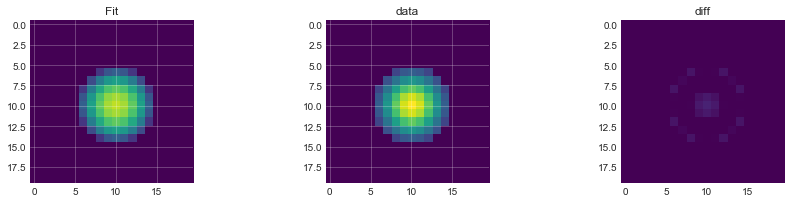

In [741]:
complete('Spherical-2', spherical_2)

### Astigmatism-3

fin.
Relative Depth:  0.61127183306
Axial-Frequency:
2 : 33.83 kHz
3 : 33.44 kHz
4 : 32.93 kHz
5 : 32.32 kHz
6 : 31.62 kHz
7 : 30.83 kHz
8 : 29.96 kHz
9 : 29.02 kHz
Radial-Frequencies:
8.43951722788e-27
2 : 135.1 kHz 135.3 kHz 0.000330175638487
8.43951722788e-27
3 : 123.8 kHz 123.8 kHz 0.00178267700376
8.43951722788e-27
4 : 114.7 kHz 114.6 kHz 0.00285790316415
8.43951722788e-27
5 : 103.9 kHz 103.8 kHz 0.00436004999954


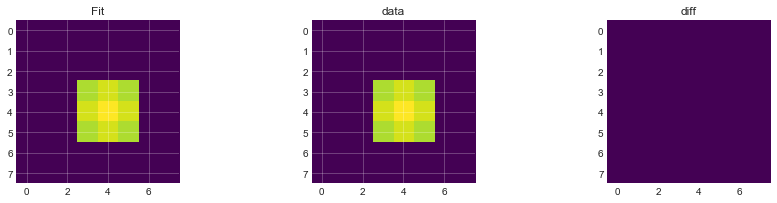

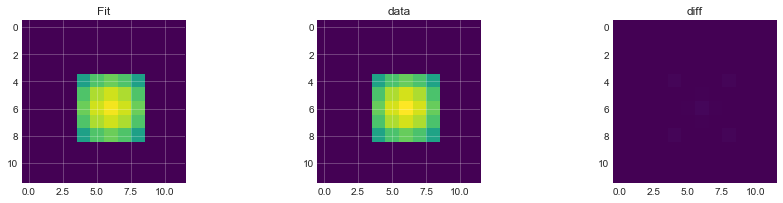

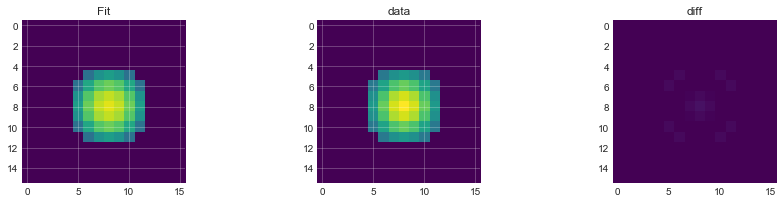

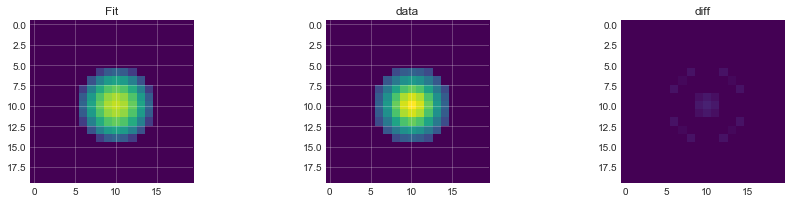

In [742]:
complete('Astigmatism-3', astigmatism_3)

### Quadrafoil-2

fin.
Relative Depth:  0.702929717107
Axial-Frequency:
2 : 35.65 kHz
3 : 35.23 kHz
4 : 34.69 kHz
5 : 34.04 kHz
6 : 33.3 kHz
7 : 32.47 kHz
8 : 31.56 kHz
9 : 30.58 kHz
Radial-Frequencies:
9.70499070408e-27
2 : 138.3 kHz 138.3 kHz 0.000214894181684
9.70499070408e-27
3 : 128.1 kHz 128.0 kHz 0.00147460598835
9.70499070408e-27
4 : 119.2 kHz 118.9 kHz 0.00241342546996
9.70499070408e-27
5 : 108.9 kHz 108.9 kHz 0.00376916134571


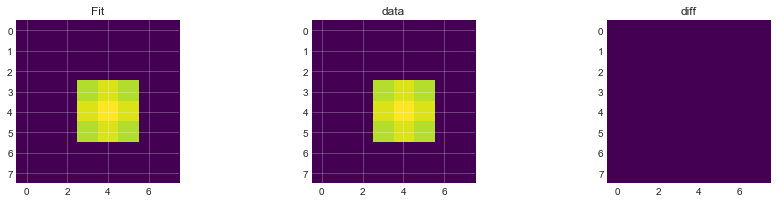

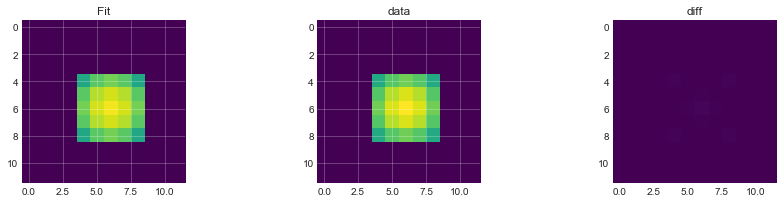

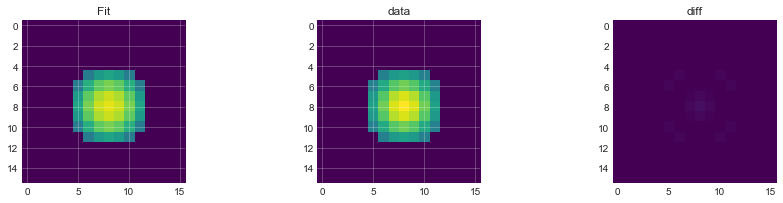

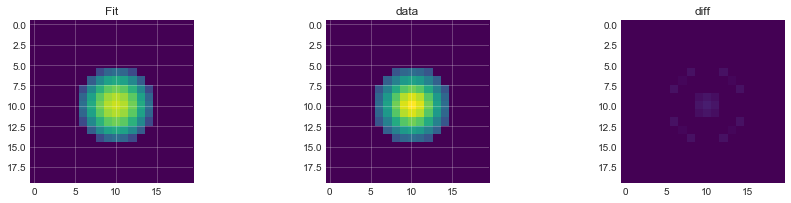

In [743]:
complete('Quadrafoil-2', quadrafoil_2)

### sexafoil

fin.
Relative Depth:  0.811455365977
Axial-Frequency:
2 : 34.69 kHz
3 : 34.36 kHz
4 : 33.94 kHz
5 : 33.44 kHz
6 : 32.85 kHz
7 : 32.18 kHz
8 : 31.44 kHz
9 : 30.64 kHz
Radial-Frequencies:
1.12033487729e-26
2 : 148.2 kHz 147.7 kHz 0.000210511671781
1.12033487729e-26
3 : 137.2 kHz 137.2 kHz 0.00142722091834
1.12033487729e-26
4 : 128.0 kHz 128.1 kHz 0.0023415112776
1.12033487729e-26
5 : 117.1 kHz 117.1 kHz 0.00369157880138


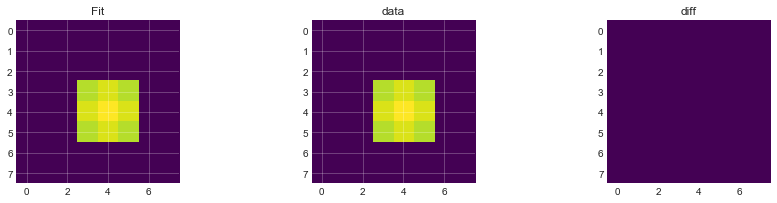

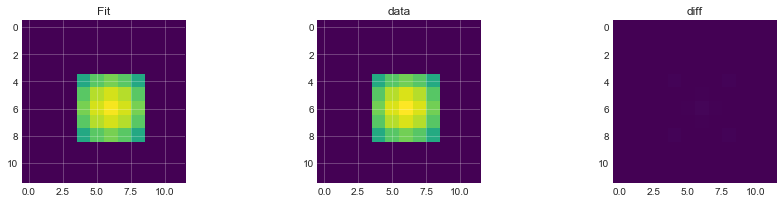

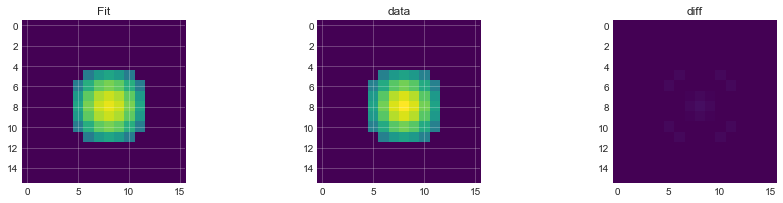

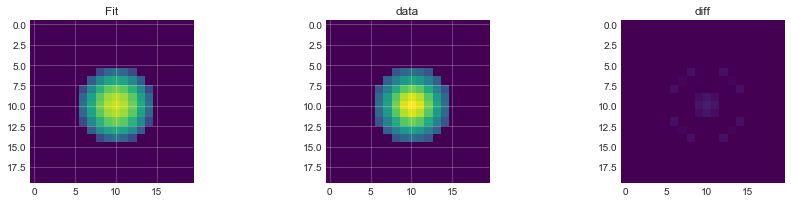

In [745]:
complete('Sexafoil', sexaFoil)

## Z=7

fin.
Relative Depth:  0.586141769327
Axial-Frequency:
2 : 31.24 kHz
3 : 30.93 kHz
4 : 30.52 kHz
5 : 30.03 kHz
6 : 29.45 kHz
7 : 28.78 kHz
8 : 28.05 kHz
9 : 27.25 kHz
Radial-Frequencies:
8.09255930451e-27
2 : 142.8 kHz 126.5 kHz 0.000268829175421
8.09255930451e-27
3 : 131.1 kHz 116.1 kHz 0.00183443578754
8.09255930451e-27
4 : 120.5 kHz 108.0 kHz 0.00301453199733
8.09255930451e-27
5 : 108.0 kHz 98.04 kHz 0.00472652887388


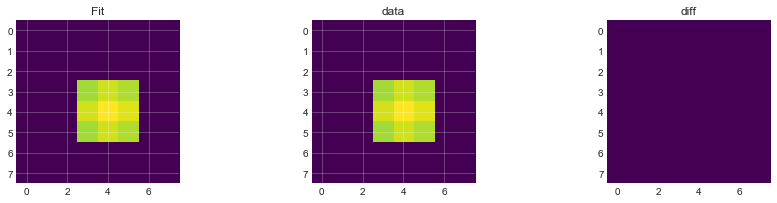

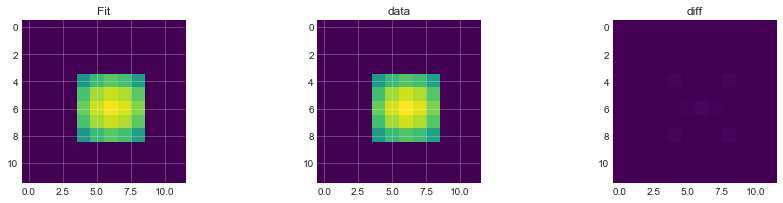

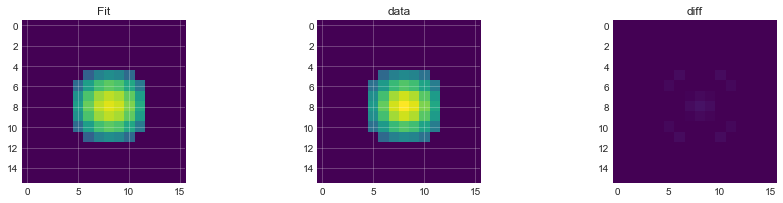

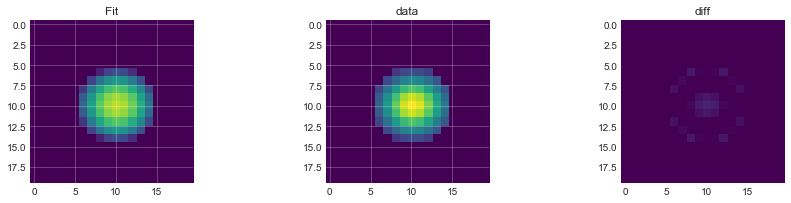

In [857]:
m=1
complete('z_7'+str(m), lambda x, y, waist, scale: zernike(7,m,x,y,waist,scale))

### 3-Tref

fin.
Relative Depth:  0.63610960401
Axial-Frequency:
2 : 34.87 kHz
3 : 34.48 kHz
4 : 33.98 kHz
5 : 33.36 kHz
6 : 32.64 kHz
7 : 31.82 kHz
8 : 30.92 kHz
9 : 29.93 kHz
Radial-Frequencies:
8.78243961445e-27
2 : 135.1 kHz 135.2 kHz 0.000260604890515
8.78243961445e-27
3 : 124.6 kHz 124.7 kHz 0.00167178336173
8.78243961445e-27
4 : 115.6 kHz 115.6 kHz 0.00270727282176
8.78243961445e-27
5 : 105.1 kHz 105.1 kHz 0.00417846655237


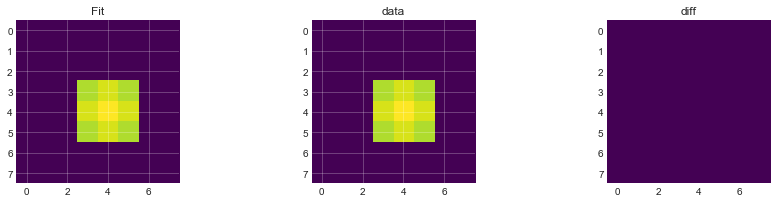

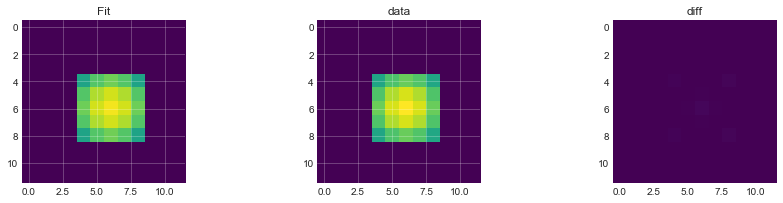

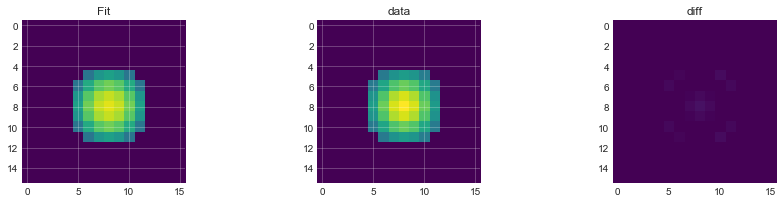

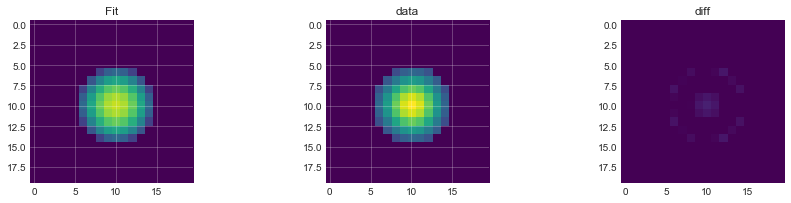

In [858]:
m=3
complete('z_7'+str(m), lambda x, y, waist, scale: zernike(7,m,x,y,waist,scale))

### 2-Quint

fin.
Relative Depth:  0.723045627191
Axial-Frequency:
2 : 35.38 kHz
3 : 35.01 kHz
4 : 34.52 kHz
5 : 33.92 kHz
6 : 33.22 kHz
7 : 32.42 kHz
8 : 31.54 kHz
9 : 30.57 kHz
Radial-Frequencies:
9.98272077527e-27
2 : 139.7 kHz 139.7 kHz 0.000210523904416
9.98272077527e-27
3 : 129.5 kHz 129.5 kHz 0.00144726441286
9.98272077527e-27
4 : 120.7 kHz 120.7 kHz 0.00236660320265
9.98272077527e-27
5 : 110.3 kHz 110.3 kHz 0.00371672129662


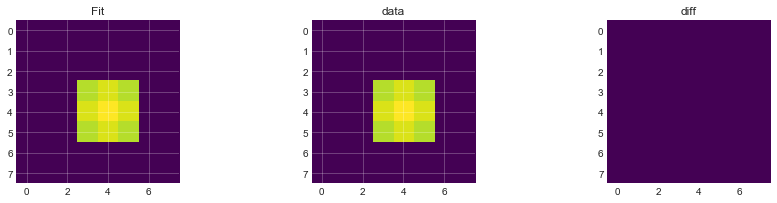

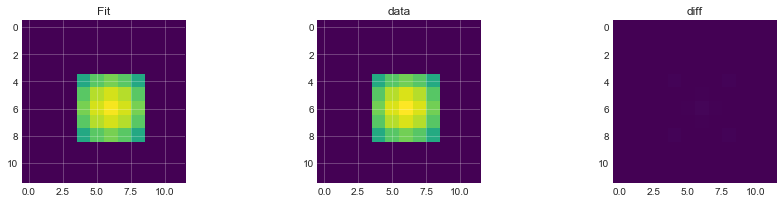

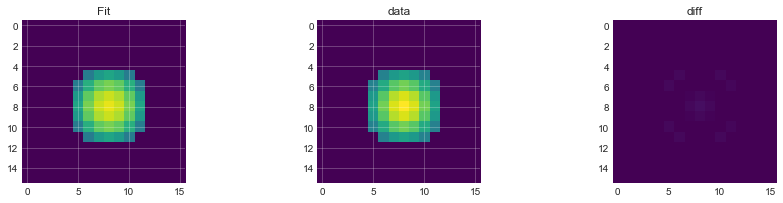

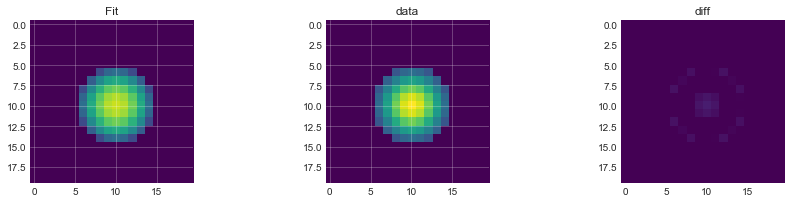

In [859]:
m=5
complete('z_7'+str(m), lambda x, y, waist, scale: zernike(7,m,x,y,waist,scale))

### Sept

fin.
Relative Depth:  0.82068090557
Axial-Frequency:
2 : 34.78 kHz
3 : 34.47 kHz
4 : 34.08 kHz
5 : 33.59 kHz
6 : 33.01 kHz
7 : 32.36 kHz
8 : 31.63 kHz
9 : 30.83 kHz
Radial-Frequencies:
1.13307210746e-26
2 : 148.4 kHz 148.3 kHz 0.000260457964606
1.13307210746e-26
3 : 138.2 kHz 138.2 kHz 0.00143494812426
1.13307210746e-26
4 : 129.1 kHz 129.0 kHz 0.00235377436339
1.13307210746e-26
5 : 117.9 kHz 117.9 kHz 0.00370963193918


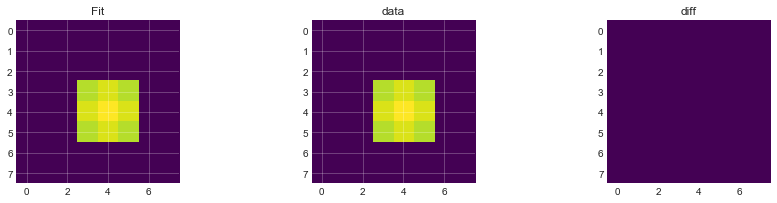

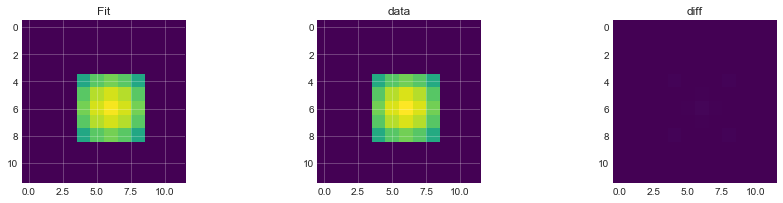

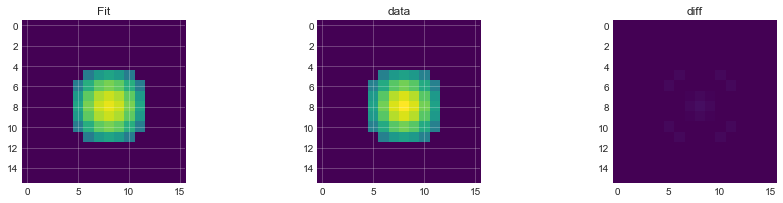

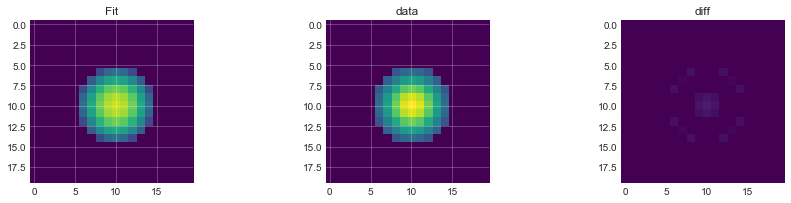

In [860]:
m=7
complete('z_7'+str(m), lambda x, y, waist, scale: zernike(7,m,x,y,waist,scale))

## Z=8

### 3rd spherical

fin.
Relative Depth:  0.578256612797
Axial-Frequency:
2 : 30.58 kHz
3 : 30.24 kHz
4 : 29.8 kHz
5 : 29.29 kHz
6 : 28.71 kHz
7 : 28.06 kHz
8 : 27.35 kHz
9 : 26.57 kHz
Radial-Frequencies:
2 : 132.7 kHz 133.1 kHz 0.000535050148199
3 : 123.5 kHz 123.4 kHz 0.00186200299112
4 : 114.1 kHz 114.1 kHz 0.0030167136375
5 : 102.8 kHz 102.9 kHz 0.00467767772974


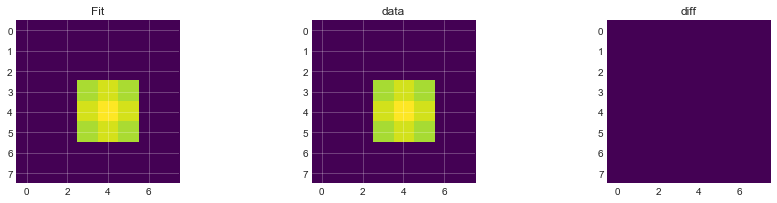

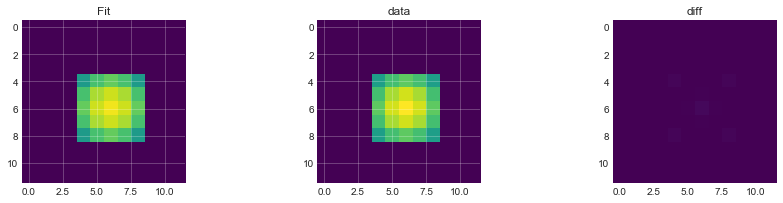

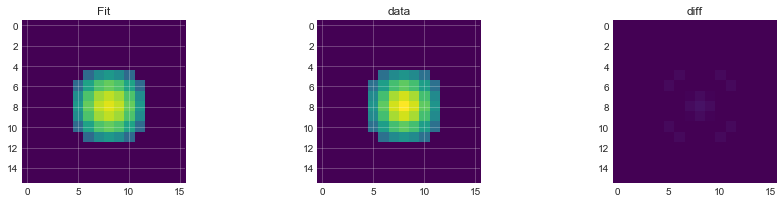

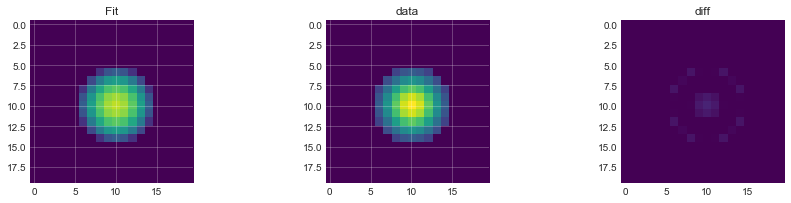

In [906]:
m=0
complete('z_8'+str(m), lambda x, y, waist, scale: zernike(8,m,x,y,waist,scale))

### 4-Astigmatism

fin.
Relative Depth:  0.598992712512
Axial-Frequency:
2 : 32.58 kHz
3 : 32.26 kHz
4 : 31.83 kHz
5 : 31.3 kHz
6 : 30.67 kHz
7 : 29.95 kHz
8 : 29.14 kHz
9 : 28.25 kHz
Radial-Frequencies:
2 : 134.8 kHz 134.8 kHz 0.000248619618882
3 : 124.1 kHz 124.0 kHz 0.0017107593992
4 : 114.5 kHz 114.5 kHz 0.00280941317026
5 : 103.6 kHz 103.6 kHz 0.00444078335585


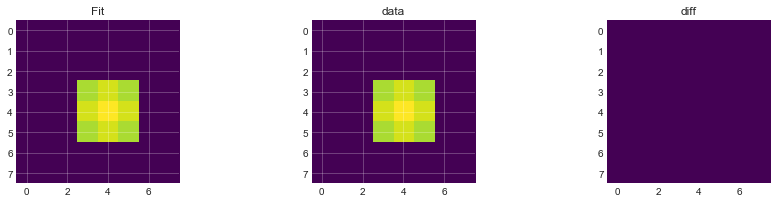

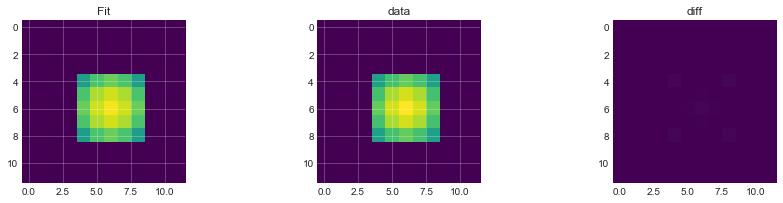

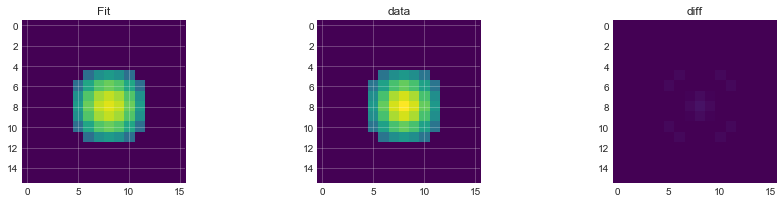

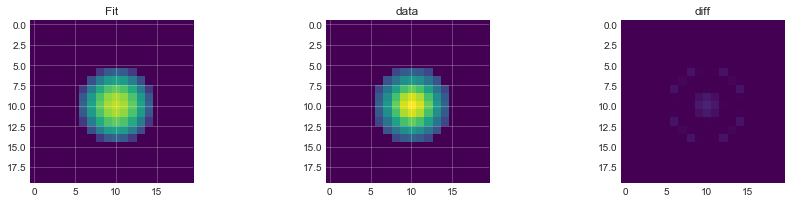

In [863]:
m=2
complete('z_8'+str(m), lambda x, y, waist, scale: zernike(8,m,x,y,waist,scale))

### 3-Quad

fin.
Relative Depth:  0.658563291913
Axial-Frequency:
2 : 35.36 kHz
3 : 34.98 kHz
4 : 34.48 kHz
5 : 33.86 kHz
6 : 33.14 kHz
7 : 32.32 kHz
8 : 31.4 kHz
9 : 30.39 kHz
Radial-Frequencies:
2 : 137.9 kHz 138.1 kHz 0.000563459164028
3 : 125.7 kHz 125.7 kHz 0.00156506947191
4 : 116.9 kHz 116.8 kHz 0.0025478131179
5 : 106.2 kHz 106.3 kHz 0.00397063210791


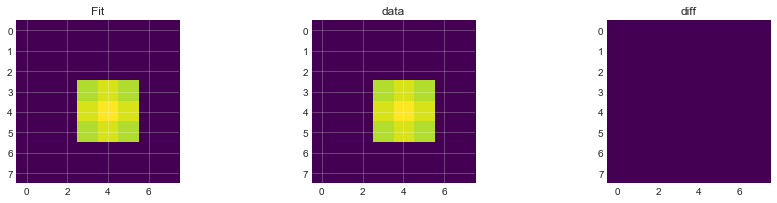

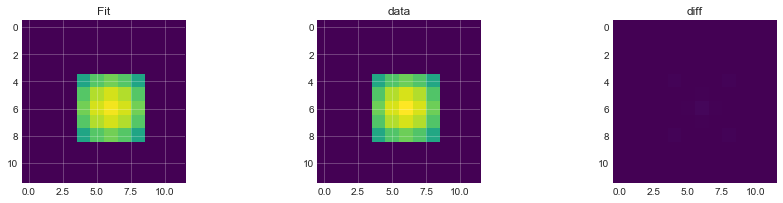

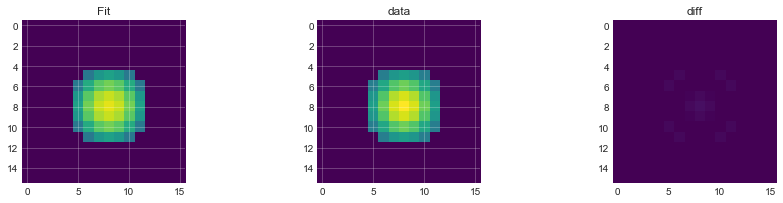

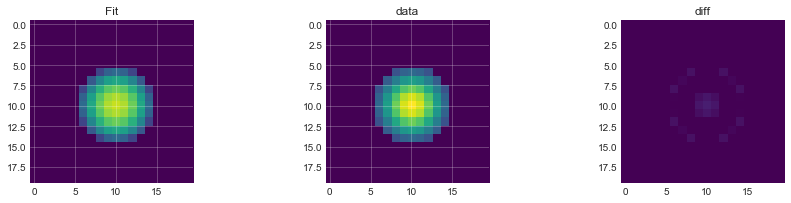

In [864]:
m=4
complete('z_8'+str(m), lambda x, y, waist, scale: zernike(8,m,x,y,waist,scale))

### 2-Sexa

fin.
Relative Depth:  0.739213958522
Axial-Frequency:
2 : 35.2 kHz
3 : 34.85 kHz
4 : 34.38 kHz
5 : 33.81 kHz
6 : 33.13 kHz
7 : 32.36 kHz
8 : 31.5 kHz
9 : 30.55 kHz
Radial-Frequencies:
2 : 140.9 kHz 141.3 kHz 0.000218661299926
3 : 130.7 kHz 130.6 kHz 0.00143387169039
4 : 122.0 kHz 122.0 kHz 0.00234702843764
5 : 111.5 kHz 111.5 kHz 0.00368812393414


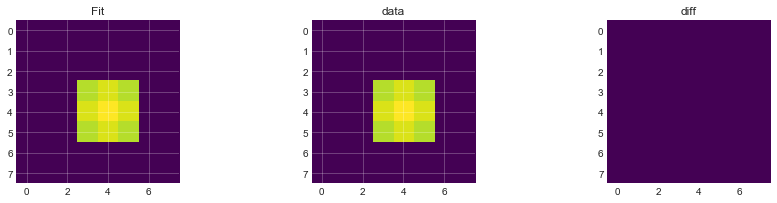

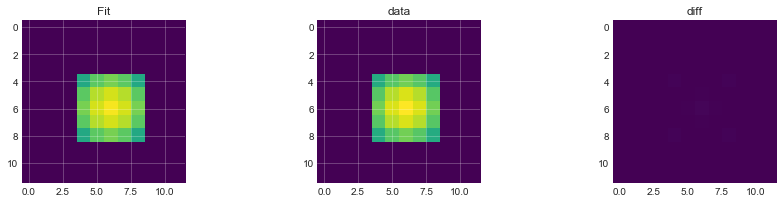

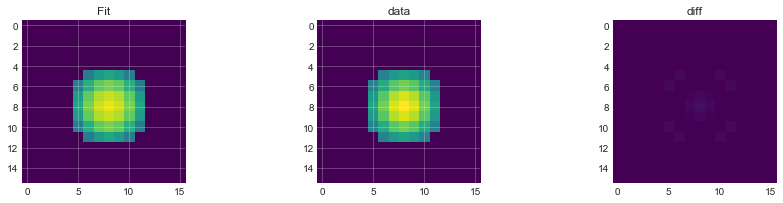

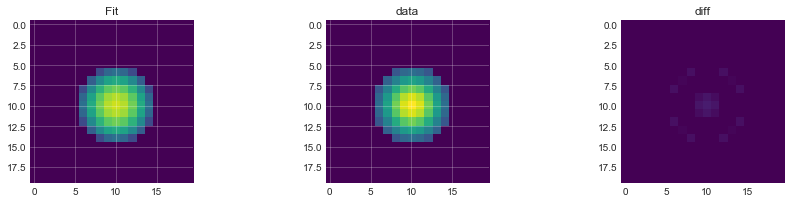

In [865]:
m=6
complete('z_8'+str(m), lambda x, y, waist, scale: zernike(8,m,x,y,waist,scale))

### octofoil

fin.
Relative Depth:  0.828658369993
Axial-Frequency:
2 : 34.93 kHz
3 : 34.63 kHz
4 : 34.24 kHz
5 : 33.76 kHz
6 : 33.2 kHz
7 : 32.54 kHz
8 : 31.81 kHz
9 : 31.01 kHz
Radial-Frequencies:
2 : 149.7 kHz 149.2 kHz 0.000241955528715
3 : 139.1 kHz 139.2 kHz 0.00144415822968
4 : 129.8 kHz 129.7 kHz 0.00236674958875
5 : 118.6 kHz 118.6 kHz 0.00372853104211


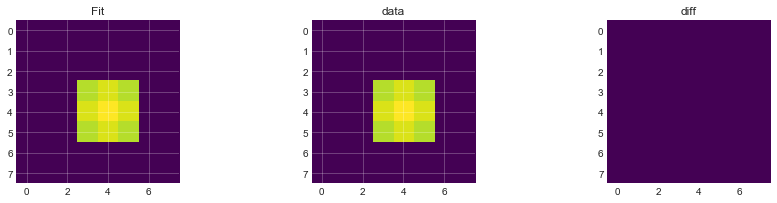

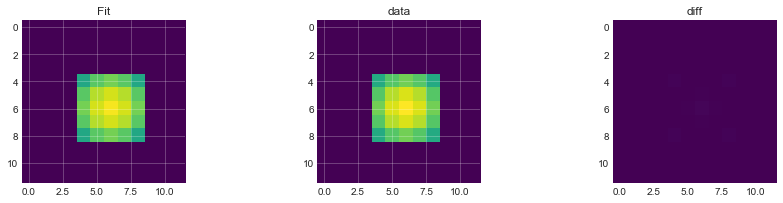

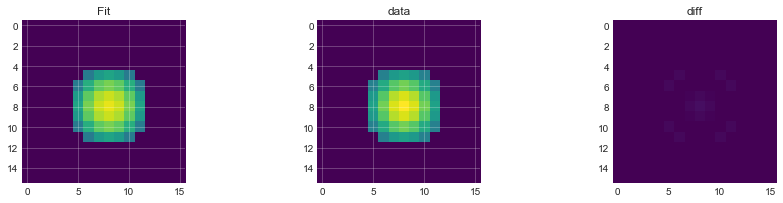

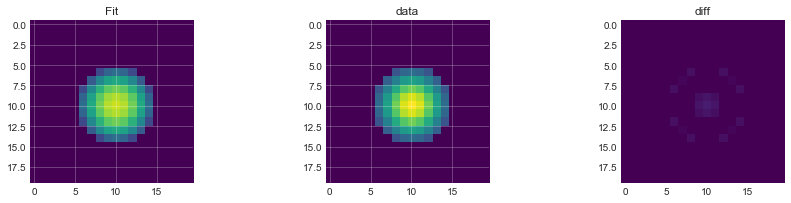

In [866]:
m=8
complete('z_8'+str(m), lambda x, y, waist, scale: zernike(8,m,x,y,waist,scale))

## Results Main Display

In [1038]:
aberrations = ['Clip', # Z_0,0
               'Sphere','2-Sphere', '3-Sphere', # (4,0) #(6,0)
               'Coma','2-Coma', '3-Coma', # (3, 1) (5, 1)
               'Astig', '2-Astig','3-Astig', '4-Astig', # (2,2) (4,2), (6,2)               
               'Tref','2-Tref', '3-Tref',# (3,3), (5,3)
               'Quad', '2-Quad', '3-Quad', # (4,4) (6,4)
               'Penta','2-Penta', #(5,5)
               'Sexa', '2-Sexa',
               'Septa',
               'Octo'] #(6,6)
radialFreqs = [(172.4, 172.4),
               (134.6, 134.6), (134.6, 134.8), (132.7, 133.1),
               (122.6, 145.5), (125.5, 142.0), (142.8, 126.5),
               (140.8, 140.4), (134.9, 135.0), (135.1, 135.3), (134.8, 134.8),
               (143.1, 143.2), (136.6, 136.6), (135.1, 135.2),
               (145.1, 145.6), (138.3, 138.3), (137.9, 138.1),
               (146.6, 146.6), (139.7, 139.7),
               (148.2, 147.7), (140.9, 141.3 ),
               (148.4, 148.3 ),
               (149.7, 149.2)]
axialFreqs = [42.88, 
              27.20, 29.88, 30.58,
              30.37, 31.72, 31.24,
              34.43, 35.17, 33.83, 32.58, 
              34.50, 35.48, 34.87,
              34.49, 35.65, 35.36,
              34.43, 35.38,
              34.69, 35.20,
              34.78,
              34.93]
trapDepths = [1, 
              0.681172642253, 0.578127491020, 0.578256612797,
              0.686063691741, 0.587366239919, 0.586141769327,
              0.737675895872, 0.642527614980, 0.611271833060, 0.598992712512,
              0.766191214461, 0.676404338098, 0.636109604010,
              0.785823008153, 0.702929717107, 0.658563291913,
              0.799823050229, 0.723045627191, 
              0.811455365977, 0.739213958522,
              0.820680905570,
              0.828658369993
             ]

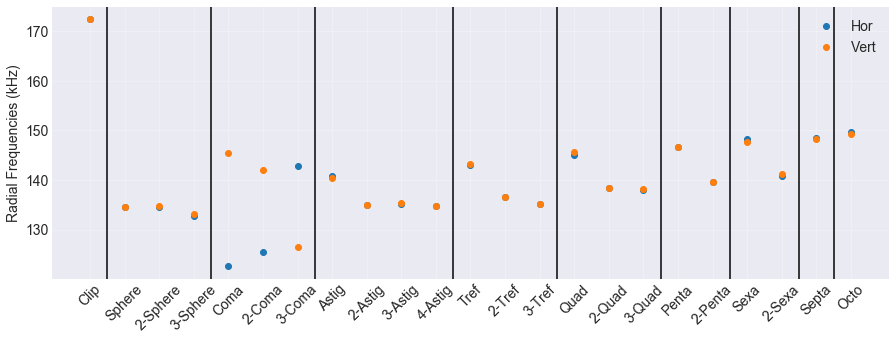

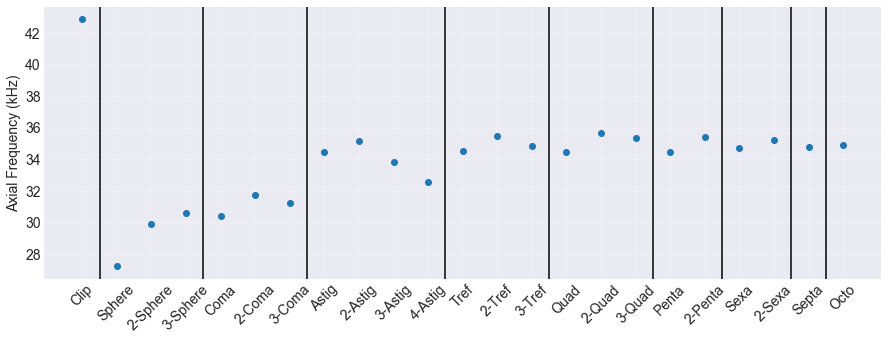

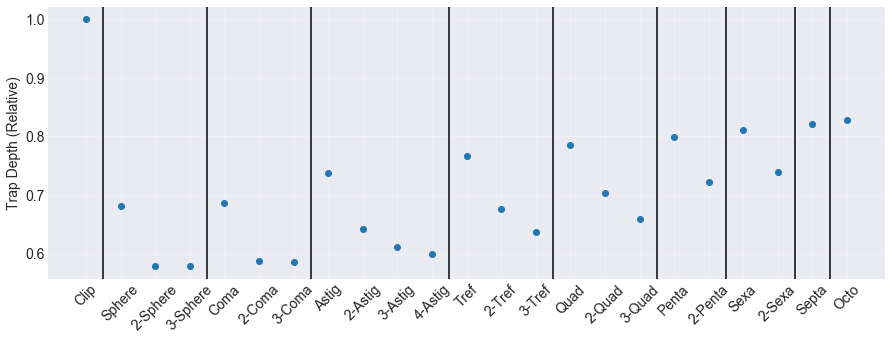

In [1041]:
borders = [0.5, 3.5, 6.5, 10.5, 13.5, 16.5, 18.5, 20.5, 21.5]
f, ax = subplots(figsize=(15,5))
ax.set_xticks(list(range(len(aberrations))))
ax.set_xticklabels(aberrations, rotation=45)
ax.plot(arr(radialFreqs)[:,0], 'o', label='Hor')
ax.plot(arr(radialFreqs)[:,1], 'o', label='Vert')
for loc in borders:
    ax.axvline(loc, color='k')
legend()
ax.set_ylabel('Radial Frequencies (kHz)')
f, ax = subplots(figsize=(15,5))
ax.set_xticks(list(range(len(aberrations))))
ax.set_xticklabels(aberrations, rotation=45)
ax.plot(axialFreqs, 'o')
for loc in borders:
    ax.axvline(loc, color='k')
ax.set_ylabel('Axial Frequency (kHz)')
f, ax = subplots(figsize=(15,5))
ax.set_xticks(list(range(len(aberrations))))
ax.set_xticklabels(aberrations, rotation=45)
ax.plot(trapDepths, 'o')
for loc in borders:
    ax.axvline(loc, color='k')
ax.set_ylabel('Trap Depth (Relative)');

## Results

In [748]:
aberrations = ['Clip', 
               'Ast', 
               'Coma', 'Tref',
               'Sphere', '2-Ast','Quad', 
               '2-Coma', '2-Tref', 'Quint',
               '2-Sphere','3-Ast','2-Quad','Sexa']
radialFreqs = [(172.4, 172.4),
               (140.8, 140.4), 
               (122.6, 145.5), (143.1, 143.2), 
               (134.6, 134.6), (134.9, 135.0), (145.1, 145.6), 
               (125.5, 142.0), (136.6, 136.6), (146.6, 146.6),
               (134.6, 134.8), (135.1, 135.3), (138.3, 138.3), (148.2, 147.7)]
axialFreqs = [42.88, 
              34.43, 
              30.37, 34.5,
              27.20, 35.17,34.49, 
              31.72, 35.48, 34.43,
              29.88, 33.83, 35.65, 34.69]
trapDepths = [1, 
              0.737675895872,
              0.686063691741, 0.766191214461,
              0.681172642253, 0.642527614980, 0.785823008153,
              0.587366239919, 0.676404338098, 0.799823050229,
              0.578127491020, 0.611271833060, 0.702929717107, 0.811455365977]

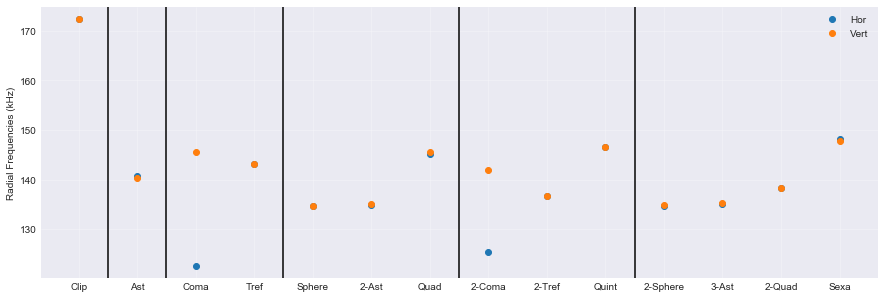

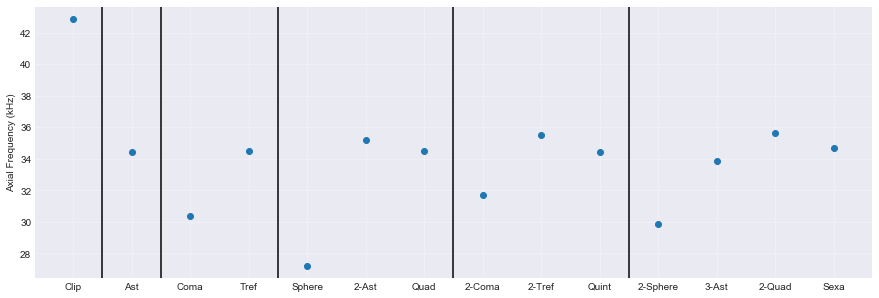

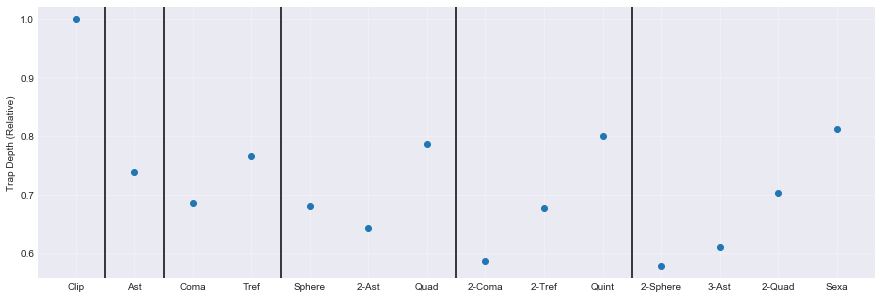

In [750]:
borders = [0.5, 1.5, 3.5, 6.5, 9.5]
f, ax = subplots(figsize=(15,5))
ax.set_xticks(list(range(len(aberrations))))
ax.set_xticklabels(aberrations)
ax.plot(arr(radialFreqs)[:,0], 'o', label='Hor')
ax.plot(arr(radialFreqs)[:,1], 'o', label='Vert')
for loc in borders:
    ax.axvline(loc, color='k')
legend()
ax.set_ylabel('Radial Frequencies (kHz)')
f, ax = subplots(figsize=(15,5))
ax.set_xticks(list(range(len(aberrations))))
ax.set_xticklabels(aberrations)
ax.plot(axialFreqs, 'o')
for loc in borders:
    ax.axvline(loc, color='k')
ax.set_ylabel('Axial Frequency (kHz)')
f, ax = subplots(figsize=(15,5))
ax.set_xticks(list(range(len(aberrations))))
ax.set_xticklabels(aberrations)
ax.plot(trapDepths, 'o')
for loc in borders:
    ax.axvline(loc, color='k')
ax.set_ylabel('Trap Depth (Relative)');

# Noise simulation

In [936]:
import random

In [989]:
850e-9 / (2e-4/numPix)

In [1010]:
y = x = np.linspace(0,1,2001)
xx, _ = np.meshgrid(x,y)

In [1004]:
randomMatrix[0]

In [1017]:
def noise2(x, y, width, scale):
    shape = arr(xx.shape)
    randomMatrix = np.random.random((int(shape[0]/10), int(shape[1]/10)))
    mag = np.sqrt(np.mean(randomMatrix**2))
    randomMatrix /= np.sqrt(mag)
    randomMatrix = np.kron(randomMatrix, np.ones((10,10)))
    finMatrix = np.zeros(xx.shape)
    finMatrix[:randomMatrix.shape[0],:randomMatrix.shape[1]] = randomMatrix
    return np.exp(-1j * 2 * np.pi * scale * finMatrix)

In [956]:
def noise(x, y, width, scale):
    """ I think most of this noise ends up evanescent"""
    randomMatrix = np.random.random(x.shape)
    mag = np.sqrt(np.mean(randomMatrix**2))
    randomMatrix /= np.sqrt(mag)
    return np.exp(-1j * 2 * np.pi * scale * randomMatrix)

In [ ]:
depths, axialFreqs, radialFreqs = [[] for _ in range(3)]
scales = np.linspace(0, 0.5, 40)
for scale in scales:
    res = complete('Noise2', noise2, aberrationScale=scale)
    depths.append(res[0])
    radialFreqs.append(res[1][0])
    axialFreqs.append(res[2][0])

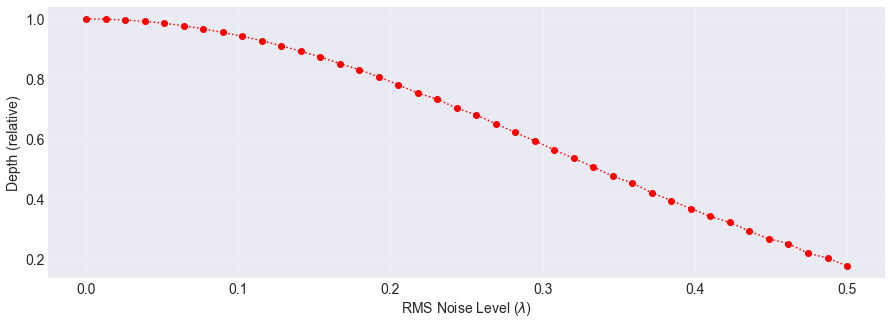

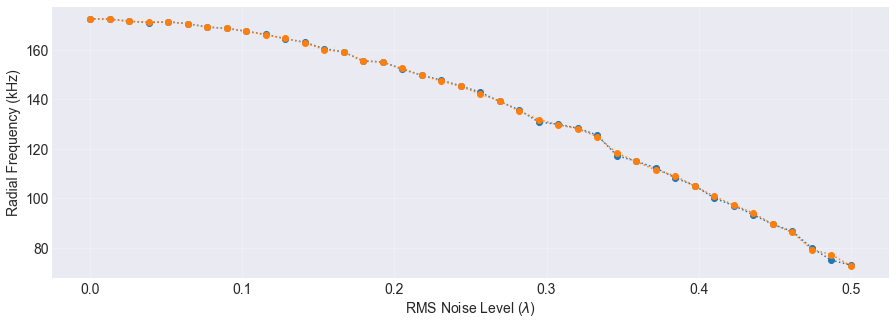

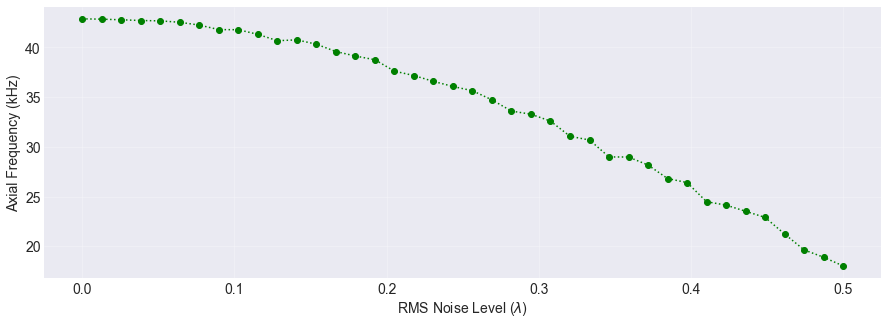

In [1028]:
plt.figure(figsize=(15,5))
plot(scales, depths,'ro:')
plt.xlabel(r'RMS Noise Level ($\lambda$)')
plt.ylabel('Depth (relative)')
plt.figure(figsize=(15,5))
plot(scales, arr(radialFreqs)[:,0]/1e3,'o:')
plot(scales, arr(radialFreqs)[:,1]/1e3,'o:')
plt.xlabel(r'RMS Noise Level ($\lambda$)')
plt.ylabel('Radial Frequency (kHz)')
plt.figure(figsize=(15,5))
plot(scales, arr(axialFreqs)/1e3,'go:')
plt.xlabel(r'RMS Noise Level ($\lambda$)')
plt.ylabel('Axial Frequency (kHz)')